In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import plotly.express as px
import numpy as np
import math
import pandas as pd
from shapely.geometry import Polygon, LineString, Point, MultiPolygon
import rdflib
from rdflib import Namespace, URIRef, BNode
from rdflib.namespace import RDF, FOAF, OWL, RDFS, XSD
from time import time #importamos la función time para capturar tiempos
import ontospy
from ontospy import *
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
#import kglab
import os
import igraph as ig
import leidenalg as la
import community as community_louvain
import networkx.algorithms.community as nx_comm
import geopandas as gpd
import json
from sklearn.cluster import DBSCAN 

In [44]:
carpetas=pd.read_csv('homicidioscdmx.csv')
agebinfo=pd.read_csv('agebspob.csv')

In [45]:
carpetas['colonia_datos'].replace(np.NaN,'No especificado',inplace=True)
carpetas['Sexo'].replace(np.NaN,'No especificado',inplace=True)
carpetas['Edad'].replace(np.NaN,'No especificado',inplace=True)


In [55]:
carpetas=carpetas[(carpetas['Año_hecho']>=2017) & (carpetas['Año_hecho']<=2022)]
carpetas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3979 entries, 0 to 4020
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0.1          3979 non-null   int64   
 1   index                 3979 non-null   int64   
 2   Unnamed: 0            3979 non-null   int64   
 3   idCarpeta             3979 non-null   float64 
 4   Año_inicio            3979 non-null   int64   
 5   Mes_inicio            3979 non-null   object  
 6   FechaInicio           3979 non-null   object  
 7   Delito                3979 non-null   object  
 8   Categoria             3979 non-null   object  
 9   Sexo                  3979 non-null   object  
 10  Edad                  3979 non-null   int32   
 11  TipoPersona           3975 non-null   object  
 12  CalidadJuridica       3979 non-null   object  
 13  competencia           3979 non-null   object  
 14  Año_hecho             3979 non-null   float64 
 15  Mes_hecho

In [56]:
carpetas['longitudrad'] = np.radians(carpetas.longitud)
carpetas['latitudrad'] = np.radians(carpetas.latitud)
carpetas.Edad.replace('No especificado','0.0',inplace=True)
carpetas.Edad = carpetas.Edad.astype(float)
carpetas.Edad = carpetas.Edad.astype(int)
edades = [0, 18, 64, float('inf')]
# Etiquetas para los grupos etarios
etiquetas_edad = ['0-18', '19-64', '65+']
mapeo2 = {'0-18': 1, '19-64': 2, '65+': 3}


carpetas['grupo_etario'] = pd.cut(carpetas['Edad'], bins=edades, labels=etiquetas_edad, right=False)
carpetas['grupo_etario2'] = carpetas['grupo_etario'].map(mapeo2)
carpetas['genero2'] = carpetas['Sexo'].replace({'Masculino':1,'Femenino':2,'No especificado':3})
carpetas['año'] = carpetas['Año_hecho']


In [57]:
tolerancia = 0.01

# Filtrar registros erróneos
registros_erroneos = carpetas[abs(carpetas['latitud'] - carpetas['longitud']) < tolerancia]

# Mostrar registros erróneos para revisarlos
print(registros_erroneos[['latitud', 'longitud']])

# Quedarte sólo con los registros correctos
carpetas = carpetas[abs(carpetas['latitud'] - carpetas['longitud']) >= tolerancia]

Empty DataFrame
Columns: [latitud, longitud]
Index: []


In [58]:
carpetas

Unnamed: 0.1   index  Unnamed: 0  idCarpeta  Año_inicio Mes_inicio  \
0                0     188         192  8325049.0        2019      Enero   
1                1     384         389  8325655.0        2019      Enero   
2                2     454         460  8325855.0        2019      Enero   
3                3     512         520  8326053.0        2019      Enero   
4                4     519         527  8326074.0        2019      Enero   
...            ...     ...         ...        ...         ...        ...   
4016          4140  965826      973633  9361524.0        2022  Diciembre   
4017          4141  968068      978150  9366167.0        2023      Enero   
4018          4142  968069      978151  9366167.0        2023      Enero   
4019          4143  968070      978152  9366167.0        2023      Enero   
4020          4144  971509      994838  9383799.0        2023    Febrero   

     FechaInicio                       Delito         Categoria       Sexo  \
0     2019-01-05  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
1     2019-01-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
2     2019-01-06  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
3     2019-01-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4     2019-01-07  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
...          ...                          ...               ...        ...   
4016  2022-12-30  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4017  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4018  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   
4019  2023-01-08  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO   Femenino   
4020  2023-02-01  HOMICIDIO_POR_ARMA_DE_FUEGO  HOMICIDIO DOLOSO  Masculino   

      ...    latitud   longitud  ageb shp  longitudrad latitudrad  \
0     ...  19.237800 -99.144230  0813 NaN    -1.730393   0.335763   
1     ...  19.395180 -99.193390  1773 NaN    -1.731251   0.338510   
2     ...  19.366760 -99.087920  0750 NaN    -1.729410   0.338014   
3     ...  19.272320 -99.135920  0067 NaN    -1.730248   0.336365   
4     ...  19.309127 -99.206300  1307 NaN    -1.731477   0.337008   
...   ...        ...        ...   ...  ..          ...        ...   
4016  ...  19.441201 -99.119868  0371 NaN    -1.729968   0.339313   
4017  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4018  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4019  ...  19.361090 -99.031424  1091 NaN    -1.728424   0.337915   
4020  ...  19.439233 -99.080478  0352 NaN    -1.729281   0.339279   

     grupo_etario grupo_etario2 genero2     año  
0           19-64             2       1  2019.0  
1           19-64             2       1  2019.0  
2           19-64             2       1  2019.0  
3           19-64             2       1  2019.0  
4           19-64             2       1  2019.0  
...           ...           ...     ...     ...  
4016         0-18             1       1  2022.0  
4017        19-64             2       1  2022.0  
4018         0-18             1       1  2022.0  
4019        19-64             2       2  2022.0  
4020        19-64             2       1  2022.0  

[3979 rows x 33 columns]

In [59]:
X=carpetas[['latitudrad','longitudrad','año','grupo_etario2','genero2']].to_numpy()

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [61]:
st = StandardScaler()
stdDf = pd.DataFrame(st.fit_transform(X))

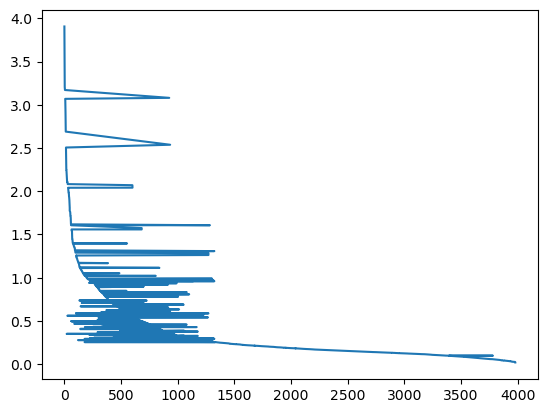

In [62]:
ns = 10
nbrs = NearestNeighbors(n_neighbors=ns).fit(stdDf)
distances, indices = nbrs.kneighbors(stdDf)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

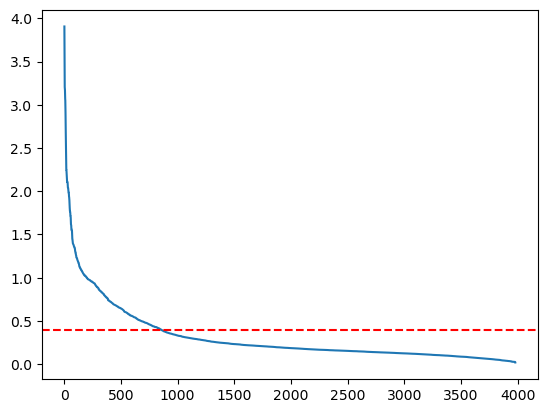

In [63]:
plt.plot(list(range(1,len(indices)+1)), distanceDec)
plt.axhline(y=0.4,color='red',linestyle='--')

In [64]:
epsilo=[0.4,0.45,.5]

In [65]:
# Crea un diccionario para almacenar los resultados de DBSCAN
resultados_dbscan = {}

# Itera sobre los valores de epsilon
for epsilon in epsilo:
    # Crea una instancia de DBSCAN con el valor actual de epsilon
    dbscan = DBSCAN(eps=epsilon, min_samples=5)
    
    # Ajusta el modelo a tus datos
    dbscan.fit(stdDf)
    
    # Almacena los resultados en el diccionario
    resultados_dbscan[epsilon] = {
        'labels': dbscan.labels_,
        'core_sample_indices': dbscan.core_sample_indices_
    }


In [66]:
carpetas['cluster1'] = resultados_dbscan[epsilo[0]]['labels']
carpetas['cluster2'] = resultados_dbscan[epsilo[1]]['labels']
carpetas['cluster3'] = resultados_dbscan[epsilo[2]]['labels']


In [67]:
# Utiliza value_counts() para contar el número de ocurrencias de cada valor único
conteo_valores1 = carpetas['cluster1'].value_counts()
conteo_valores2 = carpetas['cluster2'].value_counts()
conteo_valores3 = carpetas['cluster3'].value_counts()

# Muestra los resultados
print(conteo_valores1,conteo_valores2,conteo_valores3)

cluster1
 0     1095
 13     883
 22     671
 30     395
-1      361
 31      60
 17      59
 24      58
 1       58
 14      37
 16      28
 36      22
 23      20
 6       15
 32      14
 18      14
 15      13
 5       11
 10      10
 3        9
 35       9
 7        9
 2        9
 27       8
 25       8
 40       8
 8        8
 26       7
 20       7
 9        7
 37       7
 21       6
 29       6
 4        6
 38       6
 28       5
 11       5
 12       5
 33       5
 34       5
 39       5
 19       5
Name: count, dtype: int64 cluster2
 0     1106
 11     905
 19     672
 27     478
-1      305
 1       80
 15      60
 21      59
 12      43
 14      29
 28      27
 20      22
 13      13
 9       12
 5       12
 23      11
 22      11
 3       10
 7       10
 31       9
 2        9
 6        9
 8        9
 24       8
 34       8
 32       7
 17       7
 4        6
 26       6
 30       6
 25       5
 10       5
 16       5
 29       5
 18       5
 33       5
Name: count, dtype: 

In [68]:
# Supongamos que 'community_id' identifica la comunidad en la tabla
community_data = carpetas[['latitudrad','longitudrad','año','grupo_etario2','genero2']]
community_labels =carpetas['cluster3']

In [69]:
from sklearn.metrics import silhouette_score

# Filtrar datos excluyendo el ruido
valid_indices = community_labels != -1
filtered_data = community_data[valid_indices]
filtered_labels = community_labels[valid_indices]

# Calcular Silhouette Score si hay más de un clúster válido
if len(set(filtered_labels)) > 1:
    silhouette = silhouette_score(filtered_data, filtered_labels)
    print(f"Silhouette Score (excluyendo ruido): {silhouette}")
else:
    print("No se puede calcular el Silhouette Score: menos de 2 clústeres válidos.")


Silhouette Score (excluyendo ruido): 0.9437593048946743


In [70]:
# Calcular Silhouette Score incluyendo el ruido
if len(set(community_labels)) > 1:
    silhouette_with_noise = silhouette_score(community_data, community_labels)
    print(f"Silhouette Score (incluyendo ruido): {silhouette_with_noise}")
else:
    print("No se puede calcular el Silhouette Score: menos de 2 clústeres.")

Silhouette Score (incluyendo ruido): 0.8298648349631604


In [71]:
carpfuego1=carpetas[carpetas['Delito']=='HOMICIDIO_POR_ARMA_DE_FUEGO']
carpfuego2=carpetas[carpetas['Delito']=='HOMICIDIO_POR_ARMA_BLANCA']
carpfuego=pd.concat([carpfuego1,carpfuego2])

In [75]:
carpfuego[carpfuego['cluster3']==10].Año_hecho

1376    2020.0
1377    2020.0
1392    2020.0
1429    2020.0
1522    2020.0
1545    2020.0
1556    2020.0
1649    2020.0
1693    2020.0
1739    2020.0
1770    2020.0
1818    2020.0
1892    2020.0
1905    2020.0
1906    2020.0
1973    2020.0
1995    2020.0
2029    2020.0
2077    2020.0
2146    2020.0
2149    2020.0
2192    2020.0
2248    2020.0
2297    2020.0
2305    2020.0
2311    2020.0
2314    2020.0
2374    2020.0
2437    2020.0
2439    2020.0
2608    2020.0
Name: Año_hecho, dtype: float64

In [88]:
cluster1=carpetas[carpetas['cluster3']==10]

In [89]:
longitudes=cluster1.longitud.values
latitudes=cluster1.latitud.values

In [90]:
Puntos=[Point(lon,lat) for lon, lat in zip(longitudes, latitudes)]

In [91]:
gdf1=gpd.GeoDataFrame(geometry=Puntos)

In [92]:
alcal=gpd.read_file('ageb_pobreza.shp')
alcal=alcal.to_crs('EPSG:4326')

ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Axes: >

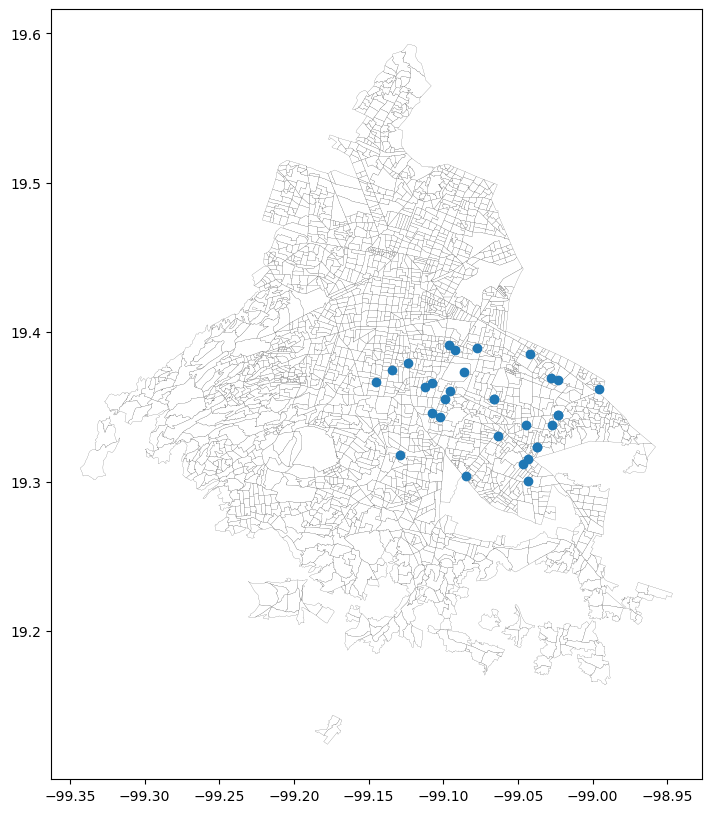

In [93]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)
gdf1.plot(ax=ax)

In [361]:
cluster1.Sexo

1376    Femenino
1377    Femenino
1392    Femenino
1429    Femenino
1522    Femenino
1545    Femenino
1556    Femenino
1649    Femenino
1693    Femenino
1739    Femenino
1770    Femenino
1818    Femenino
1892    Femenino
1905    Femenino
1906    Femenino
1973    Femenino
1995    Femenino
2029    Femenino
2077    Femenino
2146    Femenino
2149    Femenino
2192    Femenino
2248    Femenino
2297    Femenino
2305    Femenino
2311    Femenino
2314    Femenino
2374    Femenino
2437    Femenino
2439    Femenino
2608    Femenino
Name: Sexo, dtype: object

In [94]:
carpetas.cluster3.nunique()

32

In [95]:
año=cluster1.año.unique()
año=str(año[0])

In [96]:
gdf1

geometry
0   POINT (-99.03743 19.32319)
1   POINT (-99.03743 19.32319)
2   POINT (-99.04663 19.31168)
3   POINT (-99.04470 19.33767)
4   POINT (-99.02814 19.36908)
5   POINT (-99.14480 19.36657)
6   POINT (-98.99605 19.36170)
7   POINT (-99.10193 19.34331)
8   POINT (-99.04321 19.30062)
9   POINT (-99.10751 19.36607)
10  POINT (-99.06314 19.33075)
11  POINT (-99.02333 19.34470)
12  POINT (-99.13471 19.37457)
13  POINT (-99.06581 19.35500)
14  POINT (-99.06581 19.35500)
15  POINT (-99.08497 19.30349)
16  POINT (-99.04185 19.38523)
17  POINT (-99.12890 19.31801)
18  POINT (-99.02713 19.33807)
19  POINT (-99.08589 19.37319)
20  POINT (-99.09251 19.38784)
21  POINT (-99.07726 19.38923)
22  POINT (-99.11233 19.36312)
23  POINT (-99.09534 19.36037)
24  POINT (-99.02302 19.34487)
25  POINT (-99.02357 19.36772)
26  POINT (-99.10789 19.34596)
27  POINT (-99.09591 19.39158)
28  POINT (-99.04305 19.31501)
29  POINT (-99.12398 19.37947)
30  POINT (-99.09860 19.35550)

In [97]:
gdf2=gdf1.copy()

In [98]:
alcal.POBREZA.unique()

array(['(18, 34]', '[ 0, 18]', '(34, 50]', '(50, 70]',
       'Una vivienda particular habitada',
       'Sin viviendas particulares habitadas', '(70, 100]', nan],
      dtype=object)

In [99]:
gdf2['pobreza']=''
gdf2['CVE']=''
for i in range(0,len(alcal)):
    geom=alcal.geometry.iloc[i]
    pobre=alcal.POBREZA.iloc[i]
    cve=alcal.CVEGEO.iloc[i]
    for j in range(0,len(gdf2)):
        punto=gdf2.geometry.iloc[j]
        if geom.contains(punto):
            gdf2.loc[gdf2['geometry']==punto,'pobreza']= pobre
            gdf2.loc[gdf2['geometry']==punto,'CVE']= cve

In [100]:
gdf2

geometry    pobreza            CVE
0   POINT (-99.03743 19.32319)   (34, 50]  0900700013401
1   POINT (-99.03743 19.32319)   (34, 50]  0900700013401
2   POINT (-99.04663 19.31168)   [ 0, 18]  0901100011357
3   POINT (-99.04470 19.33767)   (34, 50]  0900700013863
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604
5   POINT (-99.14480 19.36657)   [ 0, 18]  0901400010863
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388
8   POINT (-99.04321 19.30062)   [ 0, 18]  0901100011145
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906
11  POINT (-99.02333 19.34470)   (34, 50]  0900700012776
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483
13  POINT (-99.06581 19.35500)   (18, 34]  0900700015111
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111
15  POINT (-99.08497 19.30349)   (34, 50]  0900700013492
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562
17  POINT (-99.12890 19.31801)   [ 0, 18]  0900300010889
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475
20  POINT (-99.09251 19.38784)   (18, 34]  0900600010700
21  POINT (-99.07726 19.38923)   (18, 34]  0900600010518
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977
24  POINT (-99.02302 19.34487)   (34, 50]  0900700012776
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A
26  POINT (-99.10789 19.34596)   (34, 50]  0900700011369
27  POINT (-99.09591 19.39158)   (18, 34]  0900600010698
28  POINT (-99.04305 19.31501)   (34, 50]  0900700015380
29  POINT (-99.12398 19.37947)   [ 0, 18]  0900600010984
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227

<Axes: >

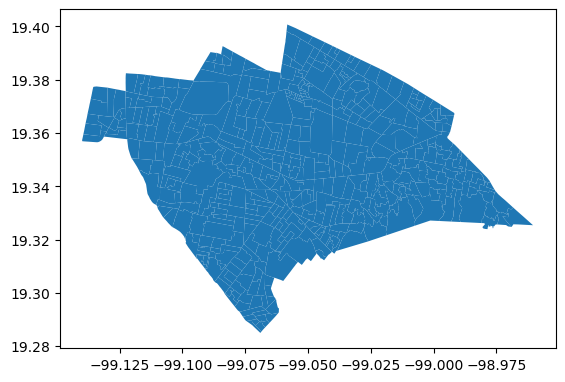

In [101]:
alcalizt=alcal[alcal['CVEGEO'].str.contains('09007')]
alcalizt.plot()

In [103]:
# Usamos 'within' para checar si cada punto está dentro de algún polígono de alcizt
# Pero como alcizt puede tener varios polígonos, primero hacemos un unary_union para juntarlos en uno solo:
union_poligonos = alcalizt.unary_union

# Filtrar puntos contenidos
gdf2 = gdf2[gdf2.geometry.within(union_poligonos)]

# Nueva forma de agregar

In [104]:
gdf2['pobreza'].value_counts()

pobreza
(18, 34]     10
(34, 50]      9
[ 0, 18]      2
(50, 70]      1
(70, 100]     1
Name: count, dtype: int64

In [105]:

gdf2['IDS']=gdf2.index.values
gdf2 = gdf2[~(gdf2['CVE'] == '')]

C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [106]:
gdf2

geometry    pobreza            CVE  IDS
0   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    0
1   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    1
3   POINT (-99.04470 19.33767)   (34, 50]  0900700013863    3
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906   10
11  POINT (-99.02333 19.34470)   (34, 50]  0900700012776   11
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
13  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   13
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   14
15  POINT (-99.08497 19.30349)   (34, 50]  0900700013492   15
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562   16
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708   22
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977   23
24  POINT (-99.02302 19.34487)   (34, 50]  0900700012776   24
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A   25
26  POINT (-99.10789 19.34596)   (34, 50]  0900700011369   26
28  POINT (-99.04305 19.31501)   (34, 50]  0900700015380   28
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227   30

In [310]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from geopy.distance import geodesic


def geod_distance(p1, p2):
    return geodesic((p1.y, p1.x), (p2.y, p2.x)).kilometers

# Calcular la matriz de distancias geodésicas
dist_matrix_geod = [
    [geod_distance(p1, p2) for p2 in gdf2['geometry']]
    for p1 in gdf2['geometry']
]

# Convertir la matriz a un DataFrame
dist_matrix_df = pd.DataFrame(dist_matrix_geod, index=gdf2.index, columns=gdf2.index)

dist_matrix_df


0          1          3          4          6          7   \
0    0.000000   0.000000   1.776033   5.172969   6.089215   7.134803   
1    0.000000   0.000000   1.776033   5.172969   6.089215   7.134803   
3    1.776033   1.776033   0.000000   3.887769   5.762087   6.046129   
4    5.172969   5.172969   3.887769   0.000000   3.468617   8.260929   
6    6.089215   6.089215   5.762087   3.468617   0.000000  11.309216   
7    7.134803   7.134803   6.046129   8.260929  11.309216   0.000000   
9    8.760831   8.760831   7.309551   8.344410  11.719120   2.586629   
10   2.828694   2.828694   2.083457   5.614295   7.837304   4.306788   
11   2.804479   2.804479   2.376153   2.745579   3.428890   8.260188   
12  11.697335  11.697335  10.301325  11.211890  14.636224   4.881826   
13   4.614700   4.614700   2.932528   4.252963   7.366042   4.010221   
14   4.614700   4.614700   2.932528   4.252963   7.366042   4.010221   
15   5.451599   5.451599   5.676897   9.400720  11.350252   4.754465   
16   6.883212   6.883212   5.272726   2.295419   5.470639   7.833978   
18   1.971550   1.971550   1.846829   3.433851   4.183585   7.881404   
19   7.521381   7.521381   5.847518   6.084159   9.523644   3.712228   
22   9.026799   9.026799   7.644137   8.869555  12.217400   2.449793   
23   7.346361   7.346361   5.884234   7.125222  10.432161   2.011515   
24   2.837861   2.837861   2.413034   2.733003   3.391325   8.292958   
25   5.140408   5.140408   3.999443   0.503665   2.966220   8.665649   
26   7.821711   7.821711   6.703135   8.761176  11.879154   0.691470   
28   1.080547   1.080547   2.514222   6.186575   7.148237   6.935612   
30   7.356169   7.356169   5.997657   7.553502  10.795801   1.394294   

           9         10         11         12  ...         16         18  \
0    8.760831  2.828694   2.804479  11.697335  ...   6.883212   1.971550   
1    8.760831  2.828694   2.804479  11.697335  ...   6.883212   1.971550   
3    7.309551  2.083457   2.376153  10.301325  ...   5.272726   1.846829   
4    8.344410  5.614295   2.745579  11.211890  ...   2.295419   3.433851   
6   11.719120  7.837304   3.428890  14.636224  ...   5.470639   4.183585   
7    2.586629  4.306788   8.260188   4.881826  ...   7.833978   7.881404   
9    0.000000  6.083956   9.154646   3.008767  ...   7.215705   8.995765   
10   6.083956  0.000000   4.458605   8.948237  ...   6.431330   3.869780   
11   9.154646  4.458605   0.000000  12.159737  ...   4.889800   0.834954   
12   3.008767  8.948237  12.159737   0.000000  ...   9.825718  12.003277   
13   4.549025  2.698806   4.606216   7.555917  ...   4.186596   4.475269   
14   4.549025  2.698806   4.606216   7.555917  ...   4.186596   4.475269   
15   7.320737  3.791041   7.922603   9.445575  ...  10.118794   7.183751   
16   7.215705  6.431330   4.889800   9.825718  ...   0.000000   5.443964   
18   8.995765  3.869780   0.834954  12.003277  ...   5.443964   0.000000   
19   2.403424  5.271082   7.290381   5.130527  ...   4.814583   7.296053   
22   0.603364  6.289018   9.570635   2.670829  ...   7.798257   9.371735   
23   1.425493  4.711174   7.761875   4.424729  ...   6.256569   7.579962   
24   9.181047  4.495620   0.037611  12.185749  ...   4.885316   0.867424   
25   8.820389  5.833860   2.548433  11.700728  ...   2.728494   3.303106   
26   2.226782  4.994709   8.886066   4.238973  ...   8.187446   8.531054   
28   8.821535  2.737641   3.884842  11.671579  ...   7.773463   3.052095   
30   1.497938  4.624856   7.998275   4.341167  ...   6.809505   7.753561   

          19         22         23         24         25         26  \
0   7.521381   9.026799   7.346361   2.837861   5.140408   7.821711   
1   7.521381   9.026799   7.346361   2.837861   5.140408   7.821711   
3   5.847518   7.644137   5.884234   2.413034   3.999443   6.703135   
4   6.084159   8.869555   7.125222   2.733003   0.503665   8.761176   
6   9.523644  12.217400  10.432161   3.391325   2.966220  11.879154   
7   3.712228   2.449793   2.011

In [311]:
import numpy as np

def find_central_point_by_community(gdf, dist_matrix_df):
    """
    Encuentra el punto central en la comunidad con el número máximo de elementos
    considerando una matriz de distancias.
    
    Args:
    - gdf (GeoDataFrame): GeoDataFrame con una columna 'comunidad' que agrupa los puntos.
    - dist_matrix_df (DataFrame): Matriz de distancias entre los índices de gdf.

    Returns:
    - central_point (list): [índice del punto central, comunidad asociada].
    """
    # Agrupar por 'comunidad' y contar el número de elementos por comunidad
    groups = gdf.groupby('CVE').count()

    # Encontrar el valor máximo y su índice correspondiente
    max_count = groups.max().max()  # Obtiene el valor máximo global
    max_group = groups[groups == max_count].dropna()  # Filtra las filas correspondientes al valor máximo
    indices = max_group.index.values  # Obtener los índices de comunidades con el valor máximo
    print("Índices con el valor máximo:", indices)

    # Inicializar variables para encontrar el punto central
    min_avg_distance = np.inf
    central_point = None

    # Iterar sobre los índices de las comunidades con el máximo valor
    for i in indices:
        # Filtrar los datos correspondientes a la comunidad actual
        dat = gdf[gdf['CVE'] == i]
        identifi = dat.index.values.tolist()  # Obtener los identificadores de los puntos

        # Calcular la distancia promedio para cada punto en esta comunidad
        for k in range(len(identifi)):
            ind1 = identifi[k]
            avg_distance = np.mean(
                [dist_matrix_df.loc[ind1, identifi[j]] for j in range(len(identifi)) if k != j]
            )
            # Actualizar el punto central si la distancia promedio es menor
            if avg_distance < min_avg_distance:
                min_avg_distance = avg_distance
                central_point = [ind1, i]
    if central_point == None: 
        
        central_point = gdf.sample(1).iloc[0]
        return central_point

    else:
        return central_point


In [312]:
central_point = find_central_point_by_community(gdf2, dist_matrix_df)
print("Punto central:", central_point)

# Acceder a las coordenadas o datos del punto central
if central_point:
    print("Datos del punto central:")
    print(gdf2.loc[central_point[0]])


Índices con el valor máximo: ['0900700012776' '0900700013401' '0900700015111']
Punto central: [0, '0900700013401']
Datos del punto central:
geometry    POINT (-99.0374279669032 19.323186366422)
pobreza                                      (34, 50]
CVE                                     0900700013401
IDS                                                 0
Name: 0, dtype: object


In [313]:
mean_distance = dist_matrix_df.values.mean()
print("Media general:", mean_distance)

Media general: 5.477615343654632


In [314]:
#mean_pob = poblacion.pob.mean()
#std_pob =poblacion.pob.std()

###lim_inf_pob = mean_pob - std_pob
###lim_sup_pob = mean_pob + std_pob

In [315]:
"""dftest1['poblacion']=''
for i in range(0,len(dftest1)):
    row=dftest1.iloc[i]
    ag=row['ageb']
    pop=poblacion[poblacion['ageb']==ag]
    if len(pop) > 0:
        dftest1['poblacion'].iloc[i]=pop['pob'].values[0]
    else:
        dftest1['poblacion'].iloc[i]=0"""

"dftest1['poblacion']=''\nfor i in range(0,len(dftest1)):\n    row=dftest1.iloc[i]\n    ag=row['ageb']\n    pop=poblacion[poblacion['ageb']==ag]\n    if len(pop) > 0:\n        dftest1['poblacion'].iloc[i]=pop['pob'].values[0]\n    else:\n        dftest1['poblacion'].iloc[i]=0"

In [316]:
central_point

[0, '0900700013401']

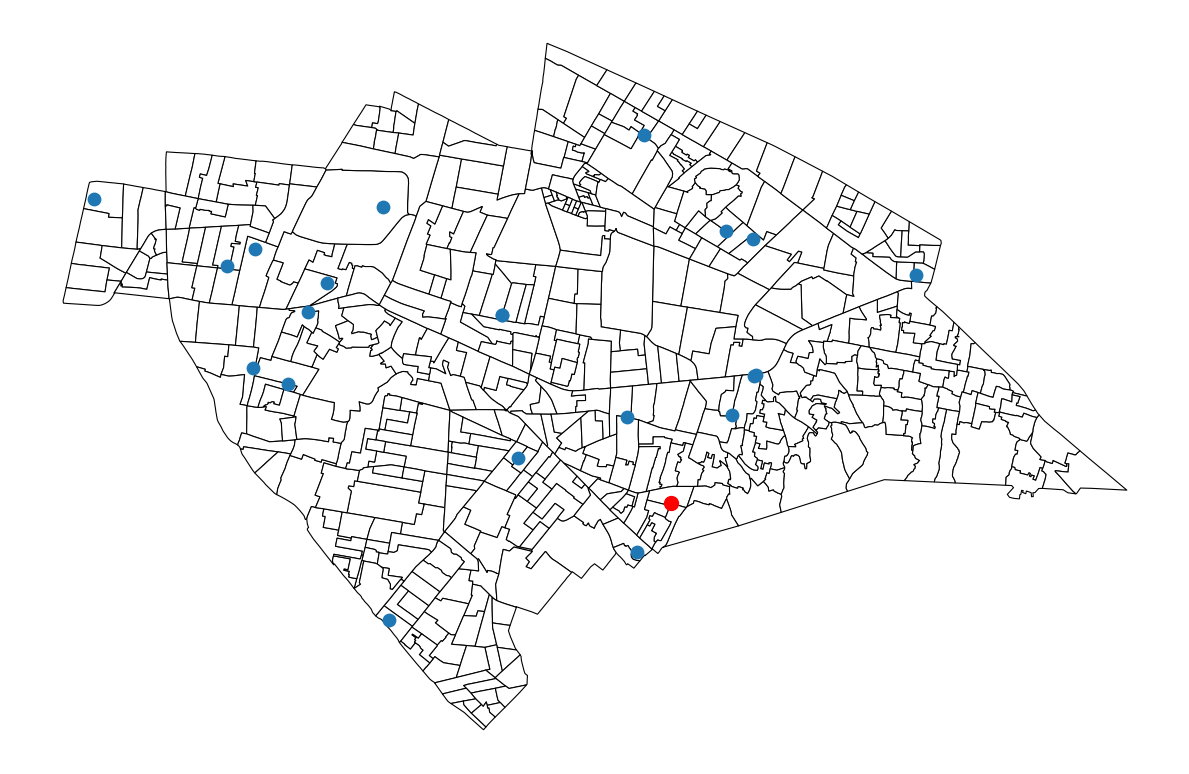

In [317]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)
root=gdf2[gdf2['IDS']==central_point[0]]
#root=root[root['comunidad']==central_points[0]]
gdf2.plot(ax=ax,markersize=80,legend=True,categorical=True)
root.plot(ax=ax,markersize=100,color='red')

plt.axis('off')
plt.tight_layout()
plt.savefig("mapa_por_cluster1_4.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [318]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [319]:

grupo

geometry   pobreza            CVE  IDS
0  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    0

In [320]:
gdf3=gdf2[gdf2['IDS'] != central_point[1]]
gdf3
#dftest2

geometry    pobreza            CVE  IDS
0   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    0
1   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    1
3   POINT (-99.04470 19.33767)   (34, 50]  0900700013863    3
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906   10
11  POINT (-99.02333 19.34470)   (34, 50]  0900700012776   11
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
13  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   13
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   14
15  POINT (-99.08497 19.30349)   (34, 50]  0900700013492   15
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562   16
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708   22
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977   23
24  POINT (-99.02302 19.34487)   (34, 50]  0900700012776   24
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A   25
26  POINT (-99.10789 19.34596)   (34, 50]  0900700011369   26
28  POINT (-99.04305 19.31501)   (34, 50]  0900700015380   28
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227   30

In [321]:
listapobreza=[]
listapobreza.extend(grupo['pobreza'].mode())

In [322]:
listapobreza

['(34, 50]']

In [323]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos

# Inicializa la columna 'pop_range' en dftest2
#dftest2['pop_range'] = ''

# Itera sobre las filas de dftest2
dftest2=gdf3.copy()
for i in range(len(dftest2)):
    row2 = dftest2.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):

            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                     geometry   pobreza            CVE  IDS
0  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    0
1  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    0
2  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    1
3  POINT (-99.04470 19.33767)  (34, 50]  0900700013863    3
4  POINT (-99.02333 19.34470)  (34, 50]  0900700012776   11
5  POINT (-99.08497 19.30349)  (34, 50]  0900700013492   15
6  POINT (-99.02302 19.34487)  (34, 50]  0900700012776   24
7  POINT (-99.10789 19.34596)  (34, 50]  0900700011369   26
8  POINT (-99.04305 19.31501)  (34, 50]  0900700015380   28


In [324]:
grupo['pobreza'].unique().tolist()

['(34, 50]']

In [325]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

9

In [326]:
dftest3 = dftest2[~dftest2['IDS'].isin(listaids)]
dftest3['pobreza'].unique()

array(['(50, 70]', '(18, 34]', '(34, 50]', '[ 0, 18]', '(70, 100]'],
      dtype=object)

In [327]:
len(dftest3)

15

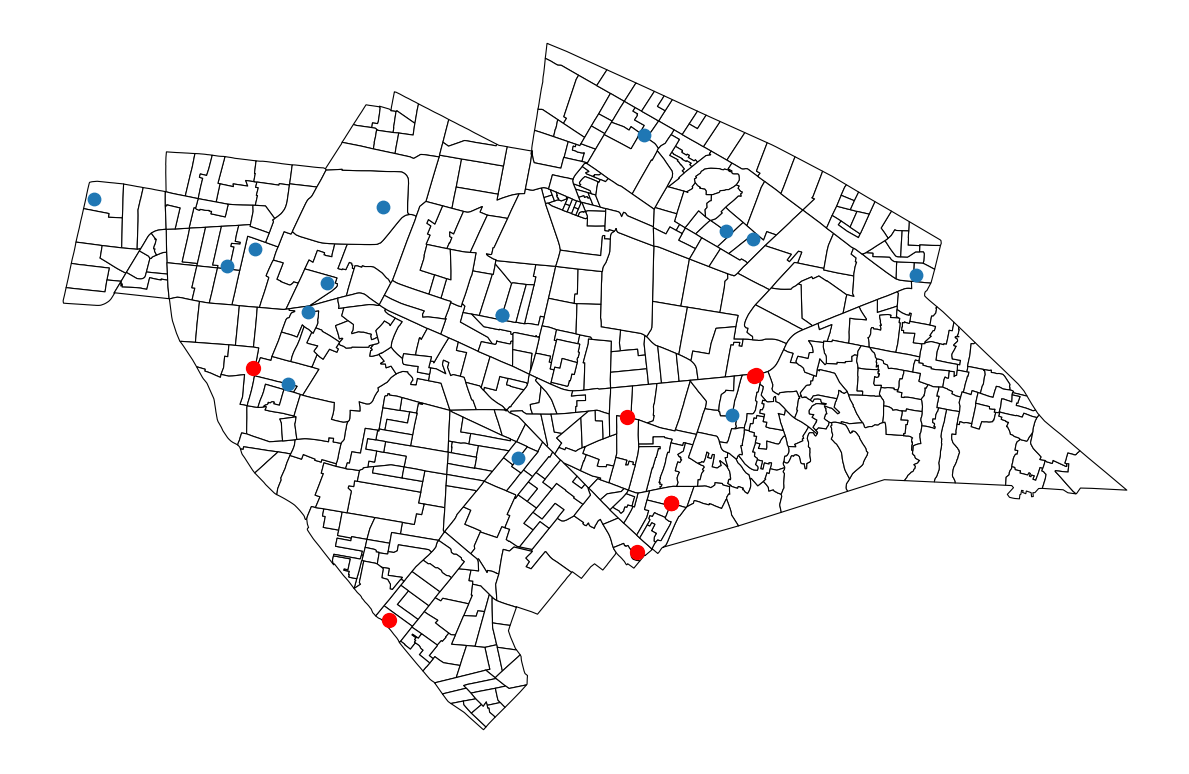

In [328]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)
grupo.plot(ax=ax,markersize=100,color='red')

dftest3.plot(ax=ax,markersize=80,categorical=True)

plt.axis('off')
plt.tight_layout()
plt.savefig("mapa_por_cluster1_5.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [329]:
grupo['newgroup']=1

In [330]:
alcal

CVEGEO   POBREZA POBREZAEX    ID  \
0     0900200010010  (18, 34]  [ 0, 20]     1   
1     0900200010025  [ 0, 18]  [ 0, 20]     2   
2     090020001003A  [ 0, 18]  [ 0, 20]     3   
3     0900200010044  [ 0, 18]  [ 0, 20]     4   
4     0900200010097  [ 0, 18]  [ 0, 20]     5   
...             ...       ...       ...   ...   
2427  0901700011488  (34, 50]  [ 0, 20]  2428   
2428  0901700011492  (34, 50]  [ 0, 20]  2429   
2429  0901700011505  [ 0, 18]  [ 0, 20]  2430   
2430  090170001151A  (18, 34]  [ 0, 20]  2431   
2431  0901700011524  (34, 50]  [ 0, 20]  2432   

                                               geometry cluster  
0     POLYGON ((-99.20307 19.51415, -99.20319 19.513...          
1     POLYGON ((-99.19662 19.51270, -99.19662 19.511...          
2     POLYGON ((-99.20658 19.51169, -99.20611 19.511...          
3     POLYGON ((-99.20530 19.51033, -99.20529 19.510...          
4     POLYGON ((-99.20573 19.50454, -99.20630 19.504...          
...                                                 ...     ...  
2427  POLYGON ((-99.05931 19.42789, -99.05934 19.427...          
2428  POLYGON ((-99.05931 19.42789, -99.05794 19.426...          
2429  POLYGON ((-99.06102 19.42776, -99.05995 19.426...          
2430  POLYGON ((-99.06253 19.42663, -99.06281 19.426...          
2431  POLYGON ((-99.05709 19.42377, -99.05723 19.422...          

[2432 rows x 6 columns]

In [331]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo1 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()
alcal['cluster']=''
# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo1 = pd.concat([alcgrupo1, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo1=gpd.GeoDataFrame(alcgrupo1,geometry=alcgrupo1.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\1894859619.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [332]:
alcgrupo1.cluster.value_counts()

cluster
1    6
Name: count, dtype: int64

In [333]:
alcgrupo1

CVEGEO   POBREZA POBREZAEX    ID  \
0  0900700011369  (34, 50]  [ 0, 20]   817   
1  0900700012776  (34, 50]  [ 0, 20]   906   
2  0900700013401  (34, 50]  [ 0, 20]   949   
3  0900700013492  (34, 50]  [ 0, 20]   952   
4  0900700013863  (34, 50]  [ 0, 20]   984   
5  0900700015380  (34, 50]  [ 0, 20]  1109   

                                            geometry  cluster  
0  POLYGON ((-99.11326 19.34489, -99.11296 19.345...        1  
1  POLYGON ((-99.02534 19.34477, -99.02475 19.344...        1  
2  POLYGON ((-99.03957 19.32325, -99.04028 19.323...        1  
3  POLYGON ((-99.08287 19.30377, -99.08256 19.303...        1  
4  POLYGON ((-99.04384 19.34295, -99.04390 19.341...        1  
5  POLYGON ((-99.04410 19.31453, -99.04403 19.314...        1

In [334]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo1)):
    row = alcgrupo1.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


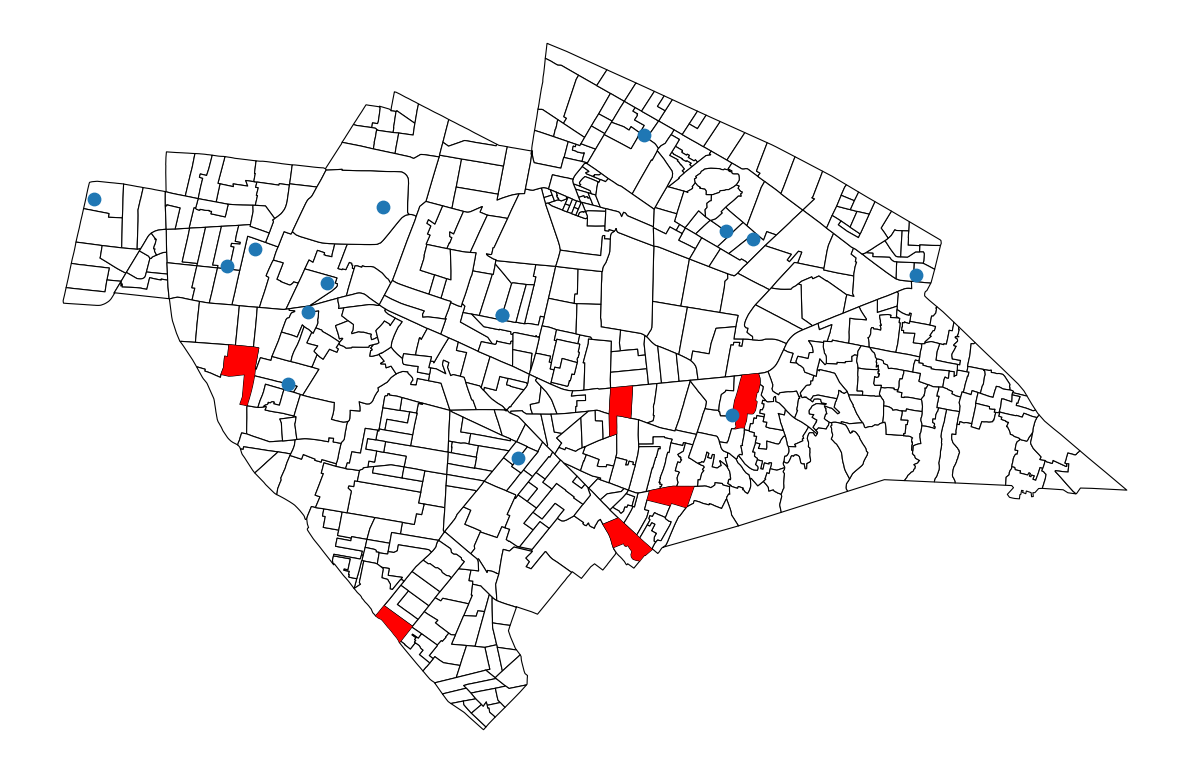

In [335]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)
alcgrupo1.plot(ax=ax,color='red')

dftest3.plot(ax=ax,markersize=80,categorical=True)

plt.axis('off')
plt.tight_layout()
plt.savefig("mapa_por_cluster1_6.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [139]:
alcshp=gpd.read_file('09a.shp').to_crs('EPSG:4326')

ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Program Files\PostgreSQL\13\share\contrib\postgis-3.1\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [140]:
gdf2

geometry    pobreza            CVE  IDS
0   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    0
1   POINT (-99.03743 19.32319)   (34, 50]  0900700013401    1
3   POINT (-99.04470 19.33767)   (34, 50]  0900700013863    3
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906   10
11  POINT (-99.02333 19.34470)   (34, 50]  0900700012776   11
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
13  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   13
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   14
15  POINT (-99.08497 19.30349)   (34, 50]  0900700013492   15
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562   16
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708   22
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977   23
24  POINT (-99.02302 19.34487)   (34, 50]  0900700012776   24
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A   25
26  POINT (-99.10789 19.34596)   (34, 50]  0900700011369   26
28  POINT (-99.04305 19.31501)   (34, 50]  0900700015380   28
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227   30

In [141]:
pobre=pd.read_csv('rezagorangos.csv',encoding='utf-8')

In [142]:
pobre

Unnamed: 0  Clave de entidad Entidad \nfederativa  Clave de municipio  \
0              0                 9     Ciudad de México                   2   
1              1                 9     Ciudad de México                   2   
2              2                 9     Ciudad de México                   2   
3              3                 9     Ciudad de México                   2   
4              4                 9     Ciudad de México                   2   
...          ...               ...                  ...                 ...   
2427        2427                 9     Ciudad de México                  17   
2428        2428                 9     Ciudad de México                  17   
2429        2429                 9     Ciudad de México                  17   
2430        2430                 9     Ciudad de México                  17   
2431        2431                 9     Ciudad de México                  17   

                Municipio Clave de \nAGEB Rango de pobreza (%)  \
0            Azcapotzalco   0900200010010             (18, 34]   
1            Azcapotzalco   0900200010025             [ 0, 18]   
2            Azcapotzalco   090020001003A             [ 0, 18]   
3            Azcapotzalco   0900200010044             [ 0, 18]   
4            Azcapotzalco   0900200010097             [ 0, 18]   
...                   ...             ...                  ...   
2427  Venustiano Carranza   0901700011488             (34, 50]   
2428  Venustiano Carranza   0901700011492             (34, 50]   
2429  Venustiano Carranza   0901700011505             [ 0, 18]   
2430  Venustiano Carranza   090170001151A             (18, 34]   
2431  Venustiano Carranza   0901700011524             (34, 50]   

     Rango de pobreza extrema (%) CVE_AGEB  Clave localidad  
0                        [ 0, 20]     0010                1  
1                        [ 0, 20]     0025                1  
2                        [ 0, 20]     003A                1  
3                        [ 0, 20]     0044                1  
4                        [ 0, 20]     0097                1  
...                           ...      ...              ...  
2427                     [ 0, 20]     1488                1  
2428                     [ 0, 20]     1492                1  
2429                     [ 0, 20]     1505                1  
2430                     [ 0, 20]     151A                1  
2431                     [ 0, 20]     1524                1  

[2432 rows x 10 columns]

In [143]:
pobre=pobre.rename(columns={'Clave de municipio':'CVE_MUN'})
pobre.CVE_MUN=pobre.CVE_MUN.replace(2,'002')
pobre.CVE_MUN=pobre.CVE_MUN.replace(3,'003')
pobre.CVE_MUN=pobre.CVE_MUN.replace(4,'004')
pobre.CVE_MUN=pobre.CVE_MUN.replace(5,'005')
pobre.CVE_MUN=pobre.CVE_MUN.replace(6,'006')
pobre.CVE_MUN=pobre.CVE_MUN.replace(7,'007')
pobre.CVE_MUN=pobre.CVE_MUN.replace(8,'008')
pobre.CVE_MUN=pobre.CVE_MUN.replace(9,'009')
pobre.CVE_MUN=pobre.CVE_MUN.replace(10,'010')
pobre.CVE_MUN=pobre.CVE_MUN.replace(11,'011')
pobre.CVE_MUN=pobre.CVE_MUN.replace(12,'012')
pobre.CVE_MUN=pobre.CVE_MUN.replace(13,'013')
pobre.CVE_MUN=pobre.CVE_MUN.replace(14,'014')
pobre.CVE_MUN=pobre.CVE_MUN.replace(15,'015')
pobre.CVE_MUN=pobre.CVE_MUN.replace(16,'016')
pobre.CVE_MUN=pobre.CVE_MUN.replace(17,'017')

In [144]:
pobre=pobre.rename(columns={'Clave de \nAGEB':'CVEGEO'})
alcshppob=pd.merge(alcshp,pobre,on=['CVEGEO'])

In [145]:
from libpysal.weights import Queen

w_queen = Queen.from_dataframe(alcshppob)

C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Luis Vilches\AppData\Roaming\Python\Python311\site

In [146]:
alcshppob

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
0     0901400010543      09       014    0001       0543   
1     0901400010967      09       014    0001       0967   
2     0901400010045      09       014    0001       0045   
3     0901400010168      09       014    0001       0168   
4     0901400010971      09       014    0001       0971   
...             ...     ...       ...     ...        ...   
2426  0901100211003      09       011    0021       1003   
2427  0901100240734      09       011    0024       0734   
2428  0901100011450      09       011    0001       1450   
2429  0901100010753      09       011    0001       0753   
2430  090110021115A      09       011    0021       115A   

                                               geometry  Unnamed: 0  \
0     POLYGON ((-99.18808 19.38117, -99.18817 19.380...        1949   
1     POLYGON ((-99.16339 19.35940, -99.16345 19.358...        1991   
2     POLYGON ((-99.16532 19.40076, -99.16546 19.400...        1899   
3     POLYGON ((-99.13476 19.39472, -99.13420 19.394...        1911   
4     POLYGON ((-99.16271 19.36467, -99.16181 19.364...        1992   
...                                                 ...         ...   
2426  POLYGON ((-98.99886 19.24043, -98.99865 19.240...        1553   
2427  POLYGON ((-98.97298 19.22324, -98.97318 19.222...        1558   
2428  POLYGON ((-99.03640 19.28327, -99.03551 19.283...        1541   
2429  POLYGON ((-99.02128 19.30522, -99.02118 19.305...        1501   
2430  POLYGON ((-99.00061 19.23334, -99.00053 19.233...        1556   

      Clave de entidad Entidad \nfederativa CVE_MUN_y      Municipio  \
0                    9     Ciudad de México       014  Benito Juárez   
1                    9     Ciudad de México       014  Benito Juárez   
2                    9     Ciudad de México       014  Benito Juárez   
3                    9     Ciudad de México       014  Benito Juárez   
4                    9     Ciudad de México       014  Benito Juárez   
...                ...                  ...       ...            ...   
2426                 9     Ciudad de México       011        Tláhuac   
2427                 9     Ciudad de México       011        Tláhuac   
2428                 9     Ciudad de México       011        Tláhuac   
2429                 9     Ciudad de México       011        Tláhuac   
2430                 9     Ciudad de México       011        Tláhuac   

                      Rango de pobreza (%)  \
0                                 [ 0, 18]   
1                                 [ 0, 18]   
2                                 [ 0, 18]   
3                                 [ 0, 18]   
4                                 [ 0, 18]   
...                                    ...   
2426  Sin viviendas particulares habitadas   
2427                              (34, 50]   
2428                              (50, 70]   
2429                              (34, 50]   
2430                              (50, 70]   

              Rango de pobreza extrema (%) CVE_AGEB_y  Clave localidad  
0                                 [ 0, 20]       0543                1  
1                                 [ 0, 20]       0967                1  
2                                 [ 0, 20]       0045                1  
3                                 [ 0, 20]       0168                1  
4                                 [ 0, 20]       0971                1  
...                                    ...        ...              ...  
2426  Sin viviendas particulares habitadas       1003               21  
2427                              [ 0, 20]       0734               24  
2428                              [ 0, 20]       1450                1  
2429                              [ 0, 20]       0753                1  
2430                              [ 0, 20]       115A               21  

[2431 rows x 15 columns]

In [147]:
grupo

geometry   pobreza            CVE  IDS  newgroup
0  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    0         1
1  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    0         1
2  POINT (-99.03743 19.32319)  (34, 50]  0900700013401    1         1
3  POINT (-99.04470 19.33767)  (34, 50]  0900700013863    3         1
4  POINT (-99.02333 19.34470)  (34, 50]  0900700012776   11         1
5  POINT (-99.08497 19.30349)  (34, 50]  0900700013492   15         1
6  POINT (-99.02302 19.34487)  (34, 50]  0900700012776   24         1
7  POINT (-99.10789 19.34596)  (34, 50]  0900700011369   26         1
8  POINT (-99.04305 19.31501)  (34, 50]  0900700015380   28         1

In [148]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 1
    
    


alcshppob[alcshppob['grupo']==1]['Rango de pobreza (%)'].unique()

array(['(34, 50]'], dtype=object)

In [149]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[1]

In [150]:
def obtener_poligonos_vecinos_extendidos(agspobtlaf, w_queen, gruposcat):
    fags = pd.DataFrame(columns=agspobtlaf.columns)

    for gru in gruposcat:
        dif = agspobtlaf[agspobtlaf.grupo == gru]
        polis = len(dif)
        
        for i in range(0, polis):
            id_poligono = dif.index[i]
            vecinos = w_queen.neighbors[id_poligono]

            prpobini = dif['Rango de pobreza (%)'].unique()

            # Obtener los polígonos vecinos
            poligonos_vecinos = agspobtlaf.iloc[vecinos]

            # Inicializar una lista para almacenar los índices de los polígonos vecinos
            indices_vecinos = []

            # Inicializar la población acumulada
            #pobla = 0
            #rango_inferior = media - std
            #rango_superior = media + std

            # Iterar sobre los vecinos del polígono inicial
            for indice_vecino in vecinos:
                # Obtener los datos del polígono vecino actual
                try:
                    datos_vecino = agspobtlaf.loc[indice_vecino]
        
                    # Verificar si el rango de pobreza del vecino es igual a alguno de los rangos de pobreza del polígono inicial
                    if (datos_vecino['Rango de pobreza (%)'] in prpobini):
                        # Agregar el índice del vecino a la lista de índices
                        indices_vecinos.append(indice_vecino)
                except KeyError as e:
                    print(f"KeyError: {e}")


            # Filtrar los polígonos vecinos según los índices acumulados
            poligonos_vecinos = agspobtlaf.loc[indices_vecinos]

            # Agregar el grupo a los polígonos vecinos
            poligonos_vecinos['grupo'] = gru
            

            # Concatenar los polígonos vecinos al DataFrame original
            dif = pd.concat([dif, poligonos_vecinos]).drop_duplicates()

        # Concatenar los resultados al DataFrame final
        fags = pd.concat([fags, dif])
    
    

    return fags

# Utilizar la función
agpobtlafveci = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [151]:
agpobtlafveci

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
914   0900700013492      09       007    0001       3492   
998   0900700011369      09       007    0001       1369   
1094  0900700012776      09       007    0001       2776   
1163  0900700013401      09       007    0001       3401   
1231  0900700013863      09       007    0001       3863   
1268  0900700015380      09       007    0001       5380   
917   0900700014325      09       007    0001       4325   
1165  0900700013488      09       007    0001       3488   
1166  0900700013505      09       007    0001       3505   
1030  0900700011208      09       007    0001       1208   
1237  0900700011388      09       007    0001       1388   
1056  0900700012757      09       007    0001       2757   
1009  0900700011710      09       007    0001       1710   
982   0900700015573      09       007    0001       5573   
1290  0900700012901      09       007    0001       2901   
1102  0900700013204      09       007    0001       3204   
1304  0900700013045      09       007    0001       3045   
1178  0900700011759      09       007    0001       1759   
1207  0900700015395      09       007    0001       5395   

                                               geometry Unnamed: 0  \
914   POLYGON ((-99.08097 19.30239, -99.08103 19.302...        951   
998   POLYGON ((-99.11084 19.34979, -99.11022 19.349...        816   
1094  POLYGON ((-99.02235 19.34321, -99.02260 19.342...        905   
1163  POLYGON ((-99.03462 19.32263, -99.03472 19.322...        948   
1231  POLYGON ((-99.04408 19.33838, -99.04412 19.337...        983   
1268  POLYGON ((-99.04536 19.31983, -99.04529 19.319...       1108   
917   POLYGON ((-99.08162 19.29880, -99.08136 19.298...       1019   
1165  POLYGON ((-99.08165 19.30838, -99.08216 19.307...        950   
1166  POLYGON ((-99.07590 19.30205, -99.07585 19.302...        952   
1030  POLYGON ((-99.10678 19.35619, -99.10576 19.356...        803   
1237  POLYGON ((-99.10225 19.34726, -99.10195 19.347...        817   
1056  POLYGON ((-99.01933 19.34154, -99.01918 19.341...        904   
1009  POLYGON ((-99.01785 19.35011, -99.01788 19.350...        841   
982   POLYGON ((-99.02496 19.33585, -99.02498 19.335...       1127   
1290  POLYGON ((-99.02928 19.33868, -99.02928 19.338...        916   
1102  POLYGON ((-99.03490 19.33332, -99.03527 19.331...        936   
1304  POLYGON ((-99.04416 19.33751, -99.04404 19.337...        926   
1178  POLYGON ((-99.04036 19.33707, -99.04138 19.336...        842   
1207  POLYGON ((-99.04519 19.31601, -99.04518 19.315...       1109   

     Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
914                 9     Ciudad de México       007  Iztapalapa   
998                 9     Ciudad de México       007  Iztapalapa   
1094                9     Ciudad de México       007  Iztapalapa   
1163                9     Ciudad de México       007  Iztapalapa   
1231                9     Ciudad de México       007  Iztapalapa   
1268                9     Ciudad de México       007  Iztapalapa   
917                 9     Ciudad de México       007  Iztapalapa   
1165                9     Ciudad de México       007  Iztapalapa   
1166                9     Ciudad de México       007  Iztapalapa   
1030                9     Ciudad de México       007  Iztapalapa   
1237                9     Ciudad de México       007  Iztapalapa   
1056                9     Ciudad de México       007  Iztapalapa   
1009                9     Ciudad de México       007  Iztapalapa   
982                 9     Ciudad de México       007  Iztapalapa   
1290                9     Ciudad de México       007  Iztapalapa   
1102                9     Ciudad de México       007  Iztapalapa   
1304                9     Ciudad de México       007  Iztapalapa   
1178                9     Ciudad de México       007  Iztapalapa   
1207                9     Ciudad de México       007  Iztapalapa   

     Rango de pobreza (%) Rango de pobreza extrema

In [152]:
agpobtlafveci=gpd.GeoDataFrame(agpobtlafveci,geometry=agpobtlafveci.geometry)

In [153]:
agpobtlafveci['Rango de pobreza (%)'].unique()

array(['(34, 50]'], dtype=object)

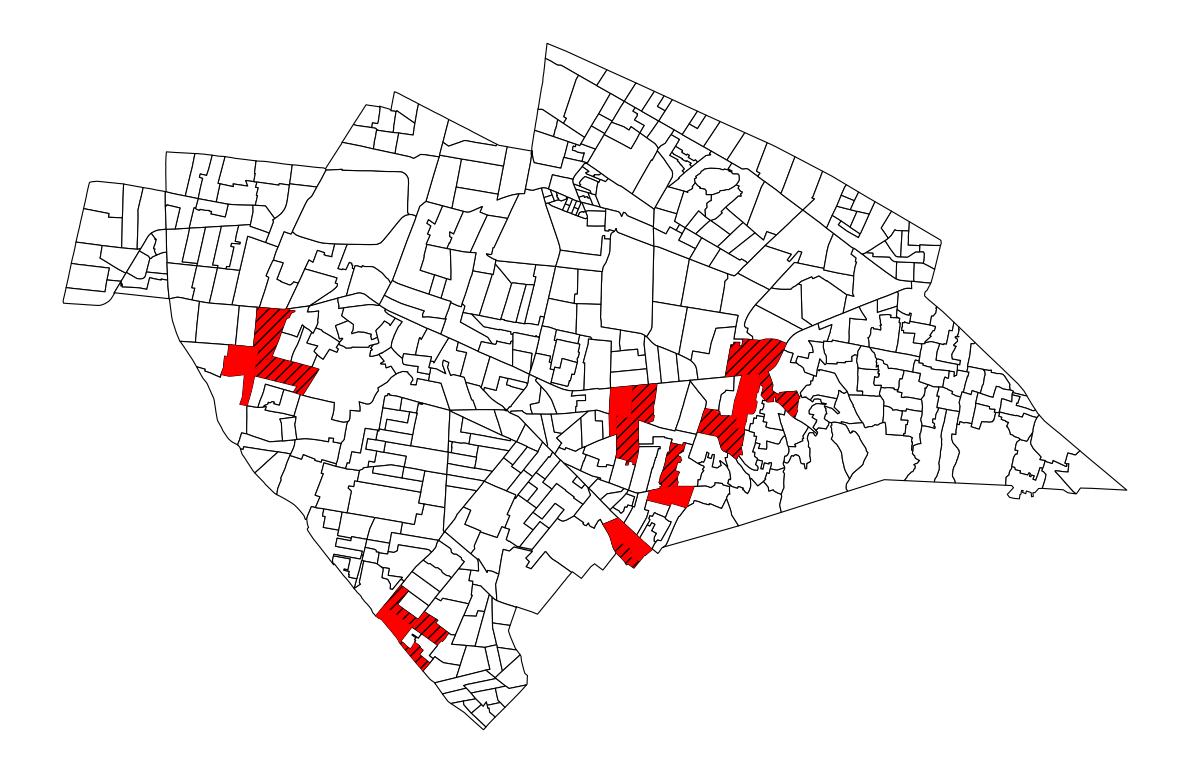

In [158]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)
#agpobtlafveci.plot(ax=ax,column='Qpob',legend=True,cmap='viridis')
#agpobtlafveci.plot(ax=ax,column='cluster',legend=True,cmap='viridis')
agpobtlafveci.plot(ax=ax,color='red',hatch='///')
alcgrupo1.plot(ax=ax,color='red')
plt.axis('off')
plt.tight_layout()
plt.savefig("mapa_por_cluster1_7.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [159]:
dftest3['pobreza'].value_counts()

pobreza
(18, 34]     10
[ 0, 18]      2
(50, 70]      1
(34, 50]      1
(70, 100]     1
Name: count, dtype: int64

In [160]:
central_point = find_central_point_by_community(dftest3, dist_matrix_df)
print("Punto central:", central_point)



Índices con el valor máximo: ['0900700015111']
Punto central: [13, '0900700015111']


In [161]:
central_point=[central_point[0],central_point[1]]
central_point

[13, '0900700015111']

In [162]:
root=dftest3[dftest3['IDS']==central_point[0]]
root

geometry   pobreza            CVE  IDS
13  POINT (-99.06581 19.35500)  (18, 34]  0900700015111   13

<Axes: >

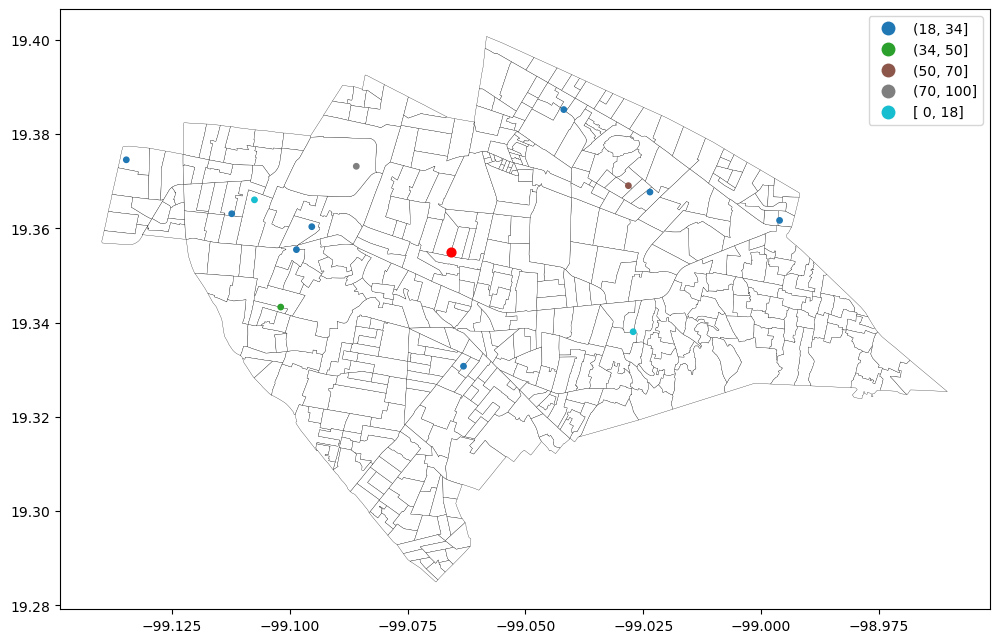

In [163]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest3.plot(ax=ax,column='pobreza',markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [164]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [165]:
grupo['pobreza']

13    (18, 34]
Name: pobreza, dtype: object

In [166]:
listapobreza

['(34, 50]']

In [167]:
dftest4=dftest3[dftest3['IDS'] != central_point[0]]
dftest4

geometry    pobreza            CVE  IDS
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906   10
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   14
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562   16
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708   22
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977   23
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A   25
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227   30

In [168]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest4)):
    row2 = dftest4.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                     geometry   pobreza            CVE  IDS
0  POINT (-99.06581 19.35500)  (18, 34]  0900700015111   13
1  POINT (-99.06314 19.33075)  (18, 34]  0900700015906   10
2  POINT (-99.06581 19.35500)  (18, 34]  0900700015111   14
3  POINT (-99.04185 19.38523)  (18, 34]  0900700013562   16
4  POINT (-99.11233 19.36312)  (18, 34]  0900700010708   22
5  POINT (-99.09534 19.36037)  (18, 34]  0900700010977   23
6  POINT (-99.02357 19.36772)  (18, 34]  090070001077A   25
7  POINT (-99.09860 19.35550)  (18, 34]  0900700011227   30


In [169]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [170]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

8

In [171]:
dftest5 = dftest4[~dftest4['IDS'].isin(listaids)]
dftest5['pobreza'].unique()

array(['(50, 70]', '(18, 34]', '(34, 50]', '[ 0, 18]', '(70, 100]'],
      dtype=object)

In [172]:
len(grupo)

8

<Axes: >

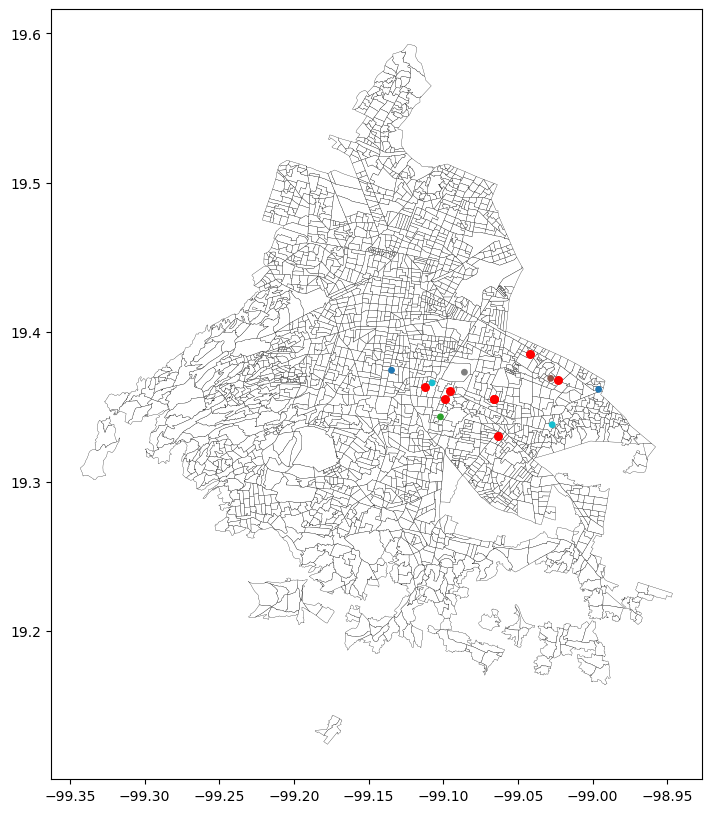

In [173]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest5.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [174]:
grupo['newgroup']=2

In [175]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo2 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo2 = pd.concat([alcgrupo2, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo2=gpd.GeoDataFrame(alcgrupo2,geometry=alcgrupo2.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\2417436692.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [176]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo1)):
    row = alcgrupo1.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

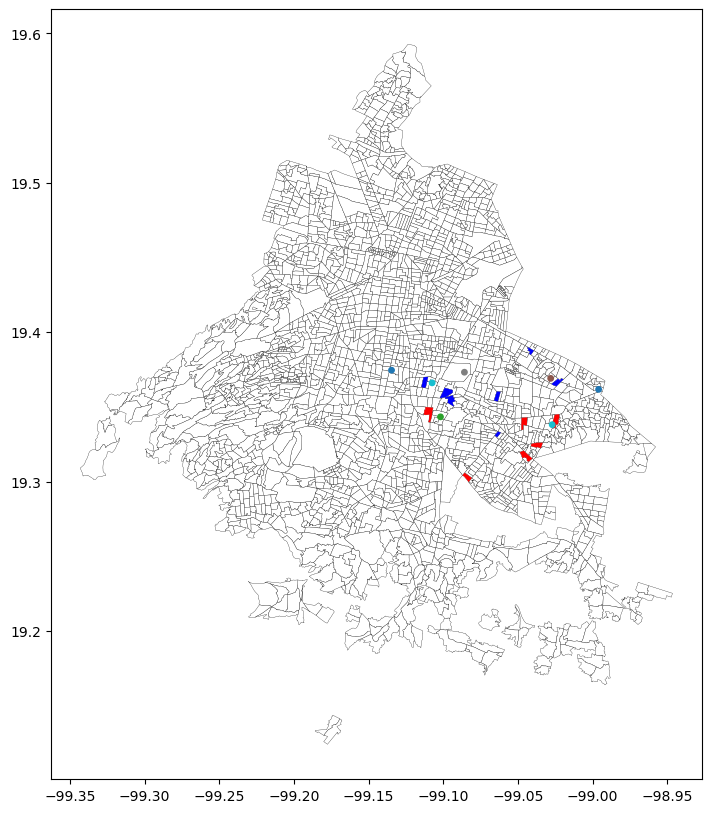

In [177]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
dftest5.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [178]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [179]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 2
    
    


alcshppob[alcshppob['grupo']==2]['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

In [180]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[2]

In [181]:

agpobtlafveci2 = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [182]:
agpobtlafveci2

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
930   0900700010708      09       007    0001       0708   
1038  0900700015906      09       007    0001       5906   
1118  0900700015111      09       007    0001       5111   
1126  0900700010977      09       007    0001       0977   
1138  0900700013562      09       007    0001       3562   
1159  090070001077A      09       007    0001       077A   
1265  0900700011227      09       007    0001       1227   
967   0900700015018      09       007    0001       5018   
1099  0900700012850      09       007    0001       2850   
1216  0900700015126      09       007    0001       5126   
885   0900700011015      09       007    0001       1015   
1264  0900700013740      09       007    0001       3740   
1273  0900700010746      09       007    0001       0746   
1080  0900700010962      09       007    0001       0962   
898   0900700010089      09       007    0001       0089   
931   0900700013613      09       007    0001       3613   
900   0900700010178      09       007    0001       0178   
1188  0900700013596      09       007    0001       3596   
1209  0900700013581      09       007    0001       3581   
928   0900700010619      09       007    0001       0619   
1269  0900700013755      09       007    0001       3755   
955   0900700013967      09       007    0001       3967   
1259  0900700013774      09       007    0001       3774   

                                               geometry Unnamed: 0  \
930   POLYGON ((-99.11000 19.36719, -99.11006 19.366...        763   
1038  POLYGON ((-99.06338 19.33353, -99.06212 19.332...       1160   
1118  POLYGON ((-99.06176 19.36006, -99.06278 19.356...       1083   
1126  POLYGON ((-99.09827 19.35646, -99.09882 19.356...        786   
1138  POLYGON ((-99.04232 19.38930, -99.04123 19.388...        956   
1159  POLYGON ((-99.01956 19.36841, -99.02147 19.366...        769   
1265  POLYGON ((-99.09335 19.35638, -99.09343 19.356...        804   
967   POLYGON ((-99.05935 19.33385, -99.05902 19.333...       1074   
1099  POLYGON ((-99.06536 19.33883, -99.06516 19.338...        912   
1216  POLYGON ((-99.06044 19.36001, -99.06054 19.359...       1084   
885   POLYGON ((-99.06554 19.36183, -99.06505 19.361...        789   
1264  POLYGON ((-99.09851 19.35613, -99.09870 19.355...        971   
1273  POLYGON ((-99.09192 19.36686, -99.09206 19.366...        766   
1080  POLYGON ((-99.10118 19.36027, -99.10112 19.360...        785   
898   POLYGON ((-99.04270 19.39382, -99.04229 19.393...        713   
931   POLYGON ((-99.03850 19.39189, -99.03851 19.391...        960   
900   POLYGON ((-99.03532 19.39043, -99.03491 19.390...        719   
1188  POLYGON ((-99.04145 19.38481, -99.04139 19.384...        959   
1209  POLYGON ((-99.04460 19.38622, -99.04442 19.386...        958   
928   POLYGON ((-99.01881 19.37539, -99.01832 19.375...        755   
1269  POLYGON ((-99.09324 19.35033, -99.09332 19.350...        972   
955   POLYGON ((-99.08685 19.35117, -99.08661 19.350...        987   
1259  POLYGON ((-99.08539 19.35587, -99.08544 19.355...        974   

     Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
930                 9     Ciudad de México       007  Iztapalapa   
1038                9     Ciudad de México       007  Iztapalapa   
1118                9     Ciudad de México       007  Iztapalapa   
1126                9     Ciudad de México       007  Iztapalapa   
1138                9     Ciudad de México       007  Iztapalapa   
1159                9     Ciudad de México       007  Iztapalapa   
1265                9     Ciudad de México       007  Iztapalapa   
967                 9     Ciudad de México       007  Iztapalapa   
1099                9     Ciudad de México       007  Iztapalapa   
1216                9     Ciudad de México       007  Iztapalapa   
885                 9     Ciudad de México       007  Iztapalapa   
1264                9     Ciudad de México       007  Iztapalapa   
1273   

In [183]:
agpobtlafveci2=gpd.GeoDataFrame(agpobtlafveci2,geometry=agpobtlafveci2.geometry)

In [184]:
agpobtlafveci2['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

<Axes: >

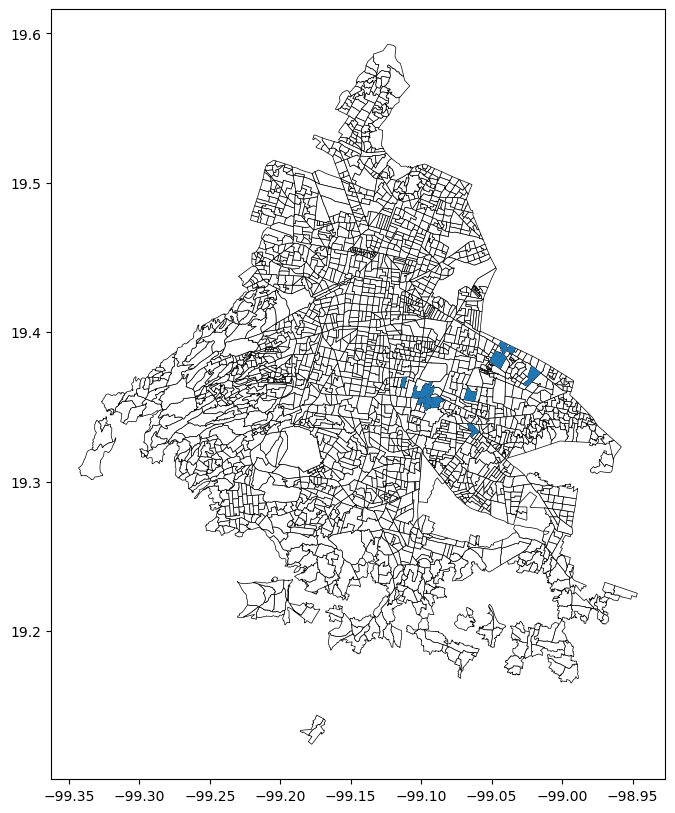

In [185]:
fig,ax=plt.subplots(figsize=(12,10))
alcshppob.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
#agpobtlafveci.plot(ax=ax,column='Qpob',legend=True,cmap='viridis')
#agpobtlafveci.plot(ax=ax,column='cluster',legend=True,cmap='viridis')
agpobtlafveci2.plot(ax=ax)

In [186]:
dftest5['pobreza'].value_counts()

pobreza
(18, 34]     2
[ 0, 18]     2
(50, 70]     1
(34, 50]     1
(70, 100]    1
Name: count, dtype: int64

In [187]:
dftest5['pobreza'].value_counts()

pobreza
(18, 34]     2
[ 0, 18]     2
(50, 70]     1
(34, 50]     1
(70, 100]    1
Name: count, dtype: int64

In [188]:
central_point = find_central_point_by_community(dftest5, dist_matrix_df)
print("Punto central:", central_point)



Índices con el valor máximo: ['0900700010483' '0900700010604' '0900700010727' '0900700011157'
 '0900700011388' '0900700012475' '0900700015003']
Punto central: geometry    POINT (-98.9960541767835 19.3617035321268)
pobreza                                       (18, 34]
CVE                                      0900700011157
IDS                                                  6
Name: 6, dtype: object


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Program

In [189]:
central_point=[central_point[0],central_point[1]]
central_point

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\610654960.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  central_point=[central_point[0],central_point[1]]


[<POINT (-98.996 19.362)>, '(18, 34]']

In [191]:
root=dftest5[dftest5['IDS']==6]
root

geometry   pobreza            CVE  IDS
6  POINT (-98.99605 19.36170)  (18, 34]  0900700011157    6

<Axes: >

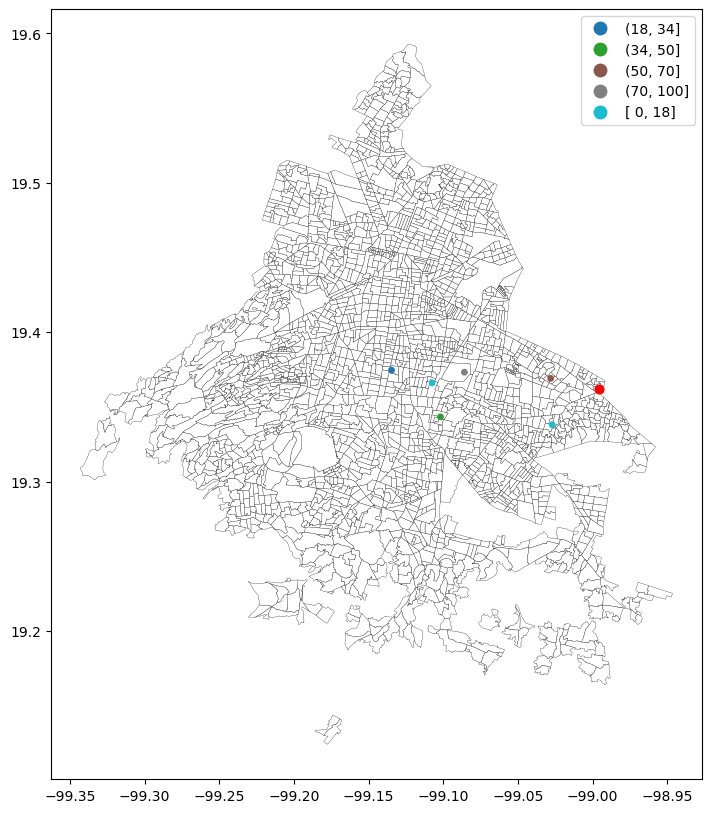

In [192]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest5.plot(ax=ax,column='pobreza',markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [193]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [194]:
grupo['pobreza']

6    (18, 34]
Name: pobreza, dtype: object

In [195]:
dftest6=dftest5[dftest5['IDS'] != central_point[0]]
dftest6

geometry    pobreza            CVE  IDS
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19

In [196]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest6)):
    row2 = dftest6.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                     geometry   pobreza            CVE  IDS
0  POINT (-98.99605 19.36170)  (18, 34]  0900700011157    6
1  POINT (-98.99605 19.36170)  (18, 34]  0900700011157    6


In [197]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [198]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [199]:
dftest7 = dftest6[~dftest6['IDS'].isin(listaids)]
dftest7['pobreza'].unique()

array(['(50, 70]', '(34, 50]', '[ 0, 18]', '(18, 34]', '(70, 100]'],
      dtype=object)

In [200]:
len(grupo)

2

<Axes: >

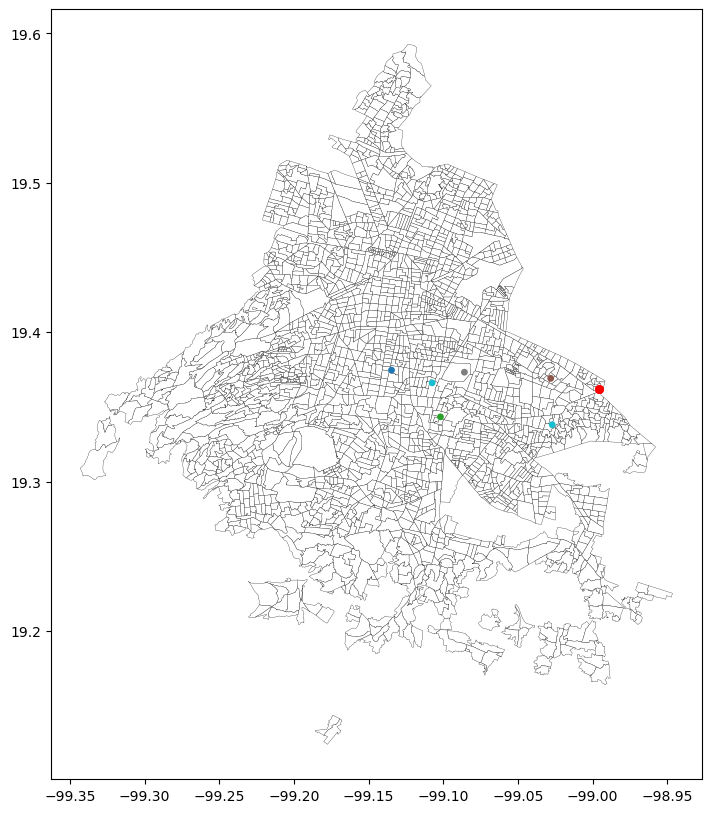

In [201]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest7.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [202]:
grupo['newgroup']=3

In [203]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo3 = gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo3 = pd.concat([alcgrupo3, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo3=gpd.GeoDataFrame(alcgrupo3,geometry=alcgrupo3.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\3921591120.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [204]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo3)):
    row = alcgrupo3.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

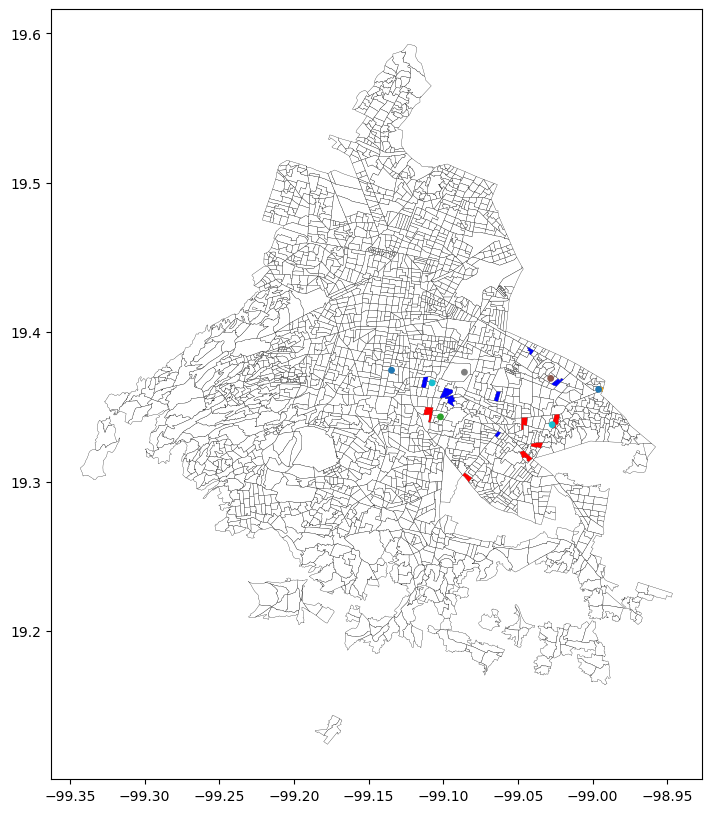

In [205]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo3.plot(ax=ax,color='ORANGE')
dftest5.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [206]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [207]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 3
    
    


alcshppob[alcshppob['grupo']==3]['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

In [208]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[3]

In [209]:

agpobtlafveci3 = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [210]:
agpobtlafveci3

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
1029  0900700011157      09       007    0001       1157   

                                               geometry Unnamed: 0  \
1029  POLYGON ((-98.99479 19.36369, -98.99479 19.363...        799   

     Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
1029                9     Ciudad de México       007  Iztapalapa   

     Rango de pobreza (%) Rango de pobreza extrema (%) CVE_AGEB_y  \
1029             (18, 34]                     [ 0, 20]       1157   

     Clave localidad grupo  
1029               1     3

In [211]:
agpobtlafveci3=gpd.GeoDataFrame(agpobtlafveci3,geometry=agpobtlafveci3.geometry)

In [212]:
agpobtlafveci3['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

<Axes: >

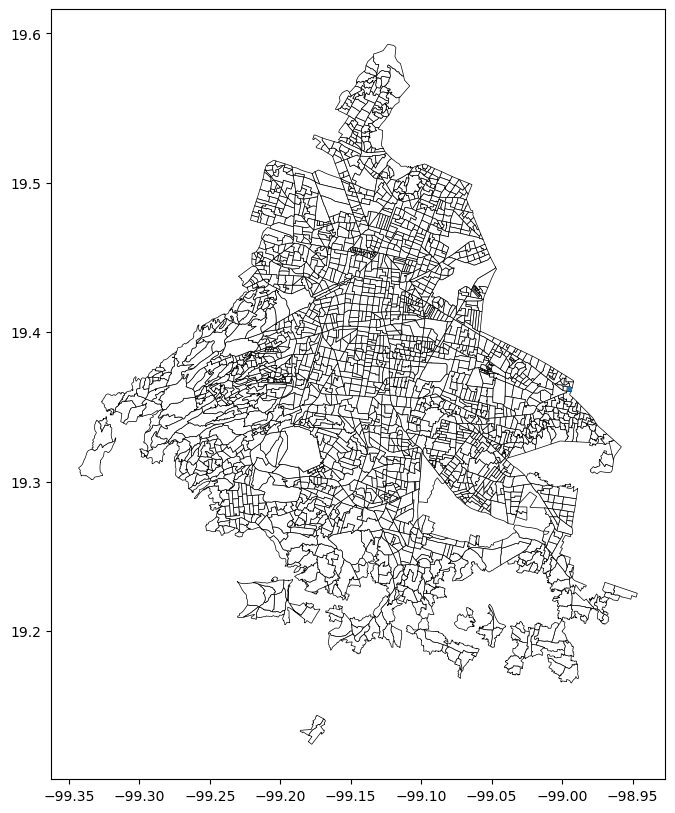

In [213]:
fig,ax=plt.subplots(figsize=(12,10))
alcshppob.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
#agpobtlafveci.plot(ax=ax,column='Qpob',legend=True,cmap='viridis')
#agpobtlafveci.plot(ax=ax,column='cluster',legend=True,cmap='viridis')
agpobtlafveci3.plot(ax=ax)

In [214]:
dftest7['pobreza'].value_counts()

pobreza
[ 0, 18]     2
(50, 70]     1
(34, 50]     1
(18, 34]     1
(70, 100]    1
Name: count, dtype: int64

In [215]:
central_point = find_central_point_by_community(dftest7, dist_matrix_df)
print("Punto central:", central_point)



Índices con el valor máximo: ['0900700010483' '0900700010604' '0900700010727' '0900700011388'
 '0900700012475' '0900700015003']
Punto central: geometry    POINT (-99.1019321401216 19.3433100192743)
pobreza                                       (34, 50]
CVE                                      0900700011388
IDS                                                  7
Name: 7, dtype: object


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Program

In [216]:
central_point=[central_point[0],central_point[1]]
central_point

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\610654960.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  central_point=[central_point[0],central_point[1]]


[<POINT (-99.102 19.343)>, '(34, 50]']

In [217]:
root=dftest7[dftest7['IDS']==7]
root

geometry   pobreza            CVE  IDS
7  POINT (-99.10193 19.34331)  (34, 50]  0900700011388    7

<Axes: >

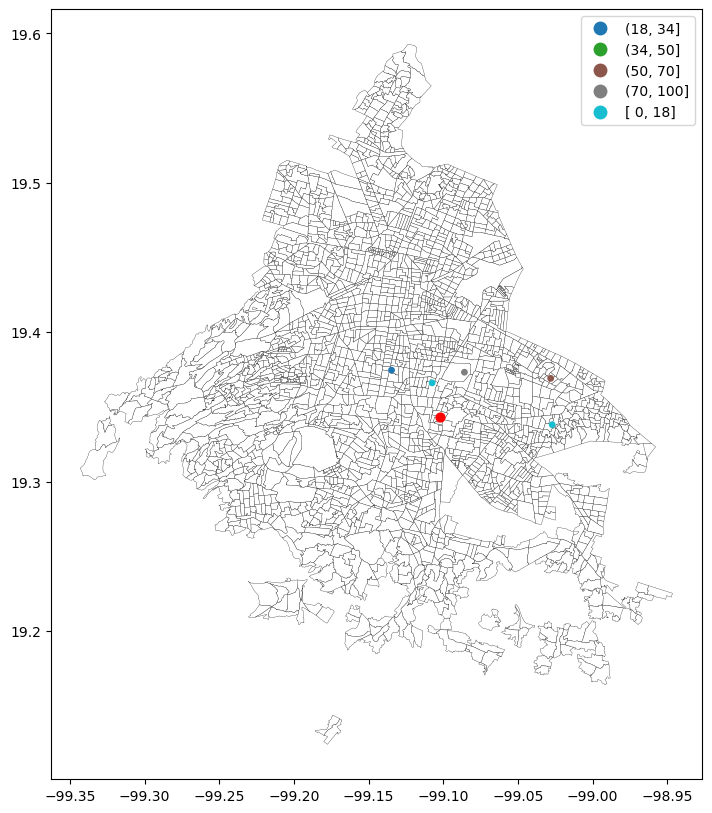

In [218]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest7.plot(ax=ax,column='pobreza',markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [219]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [220]:
grupo['pobreza']

7    (34, 50]
Name: pobreza, dtype: object

In [221]:
listapobreza

['(34, 50]']

In [224]:
dftest8=dftest7[dftest7['IDS'] != 7]
dftest4

geometry    pobreza            CVE  IDS
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
6   POINT (-98.99605 19.36170)   (18, 34]  0900700011157    6
7   POINT (-99.10193 19.34331)   (34, 50]  0900700011388    7
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
10  POINT (-99.06314 19.33075)   (18, 34]  0900700015906   10
12  POINT (-99.13471 19.37457)   (18, 34]  0900700010483   12
14  POINT (-99.06581 19.35500)   (18, 34]  0900700015111   14
16  POINT (-99.04185 19.38523)   (18, 34]  0900700013562   16
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19
22  POINT (-99.11233 19.36312)   (18, 34]  0900700010708   22
23  POINT (-99.09534 19.36037)   (18, 34]  0900700010977   23
25  POINT (-99.02357 19.36772)   (18, 34]  090070001077A   25
30  POINT (-99.09860 19.35550)   (18, 34]  0900700011227   30

In [225]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest8)):
    row2 = dftest8.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                     geometry   pobreza            CVE  IDS
0  POINT (-99.10193 19.34331)  (34, 50]  0900700011388    7
1  POINT (-99.10193 19.34331)  (34, 50]  0900700011388    7


In [226]:
grupo['pobreza'].unique()

array(['(34, 50]'], dtype=object)

In [227]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [228]:
dftest9 = dftest8[~dftest8['IDS'].isin(listaids)]
dftest9['pobreza'].unique()

array(['(50, 70]', '[ 0, 18]', '(18, 34]', '(70, 100]'], dtype=object)

In [229]:
len(grupo)

2

<Axes: >

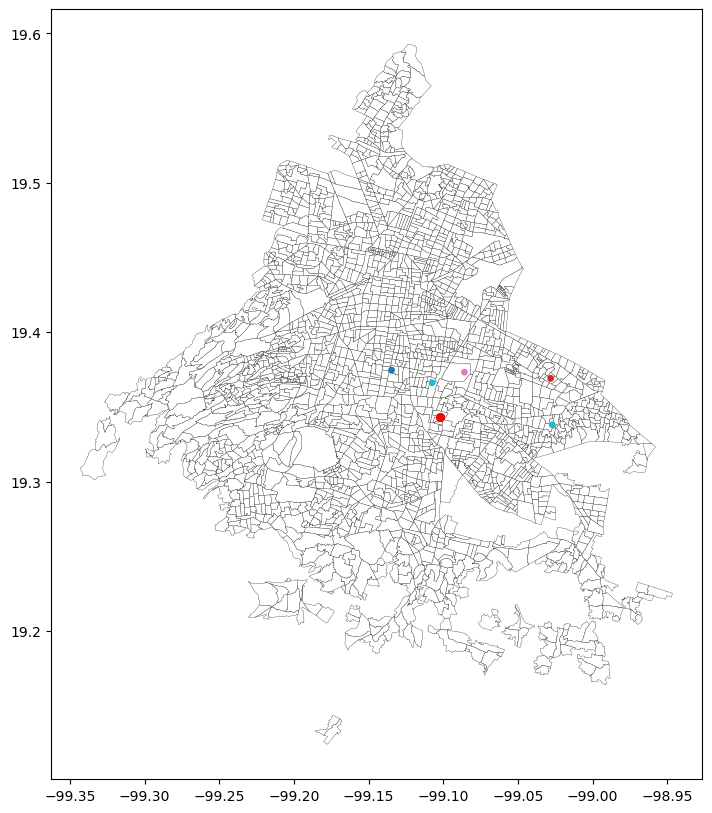

In [230]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest9.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [231]:
grupo['newgroup']=4

In [232]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo4= gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo4 = pd.concat([alcgrupo4, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo4=gpd.GeoDataFrame(alcgrupo4,geometry=alcgrupo4.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\761857396.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [233]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo4)):
    row = alcgrupo4.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

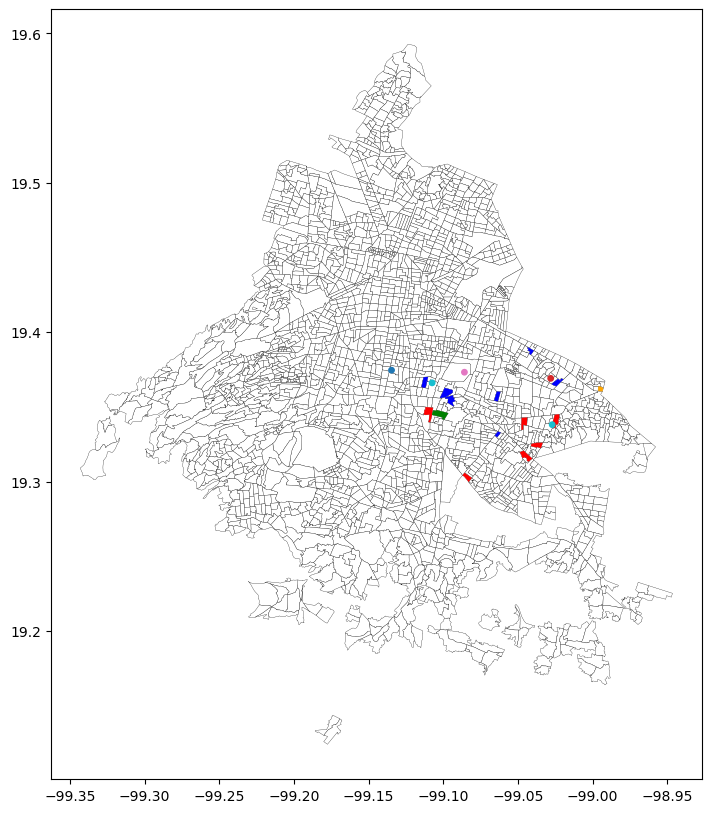

In [234]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo3.plot(ax=ax,color='orange')
alcgrupo4.plot(ax=ax,color='green')
dftest9.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [235]:
grupo['pobreza'].unique()

array(['(34, 50]'], dtype=object)

In [236]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 4
    
    


alcshppob[alcshppob['grupo']==4]['Rango de pobreza (%)'].unique()

array(['(34, 50]'], dtype=object)

In [237]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[4]

In [238]:

agpobtlafveci4 = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [239]:
agpobtlafveci4

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
1237  0900700011388      09       007    0001       1388   
998   0900700011369      09       007    0001       1369   
1030  0900700011208      09       007    0001       1208   
1221  0900700013825      09       007    0001       3825   

                                               geometry Unnamed: 0  \
1237  POLYGON ((-99.10225 19.34726, -99.10195 19.347...        817   
998   POLYGON ((-99.11084 19.34979, -99.11022 19.349...        816   
1030  POLYGON ((-99.10678 19.35619, -99.10576 19.356...        803   
1221  POLYGON ((-99.10105 19.34189, -99.10096 19.341...        979   

     Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
1237                9     Ciudad de México       007  Iztapalapa   
998                 9     Ciudad de México       007  Iztapalapa   
1030                9     Ciudad de México       007  Iztapalapa   
1221                9     Ciudad de México       007  Iztapalapa   

     Rango de pobreza (%) Rango de pobreza extrema (%) CVE_AGEB_y  \
1237             (34, 50]                     [ 0, 20]       1388   
998              (34, 50]                     [ 0, 20]       1369   
1030             (34, 50]                     [ 0, 20]       1208   
1221             (34, 50]                     [ 0, 20]       3825   

     Clave localidad grupo  
1237               1     4  
998                1     4  
1030               1     4  
1221               1     4

In [240]:
agpobtlafveci4=gpd.GeoDataFrame(agpobtlafveci4,geometry=agpobtlafveci4.geometry)

In [241]:
agpobtlafveci4['Rango de pobreza (%)'].unique()

array(['(34, 50]'], dtype=object)

<Axes: >

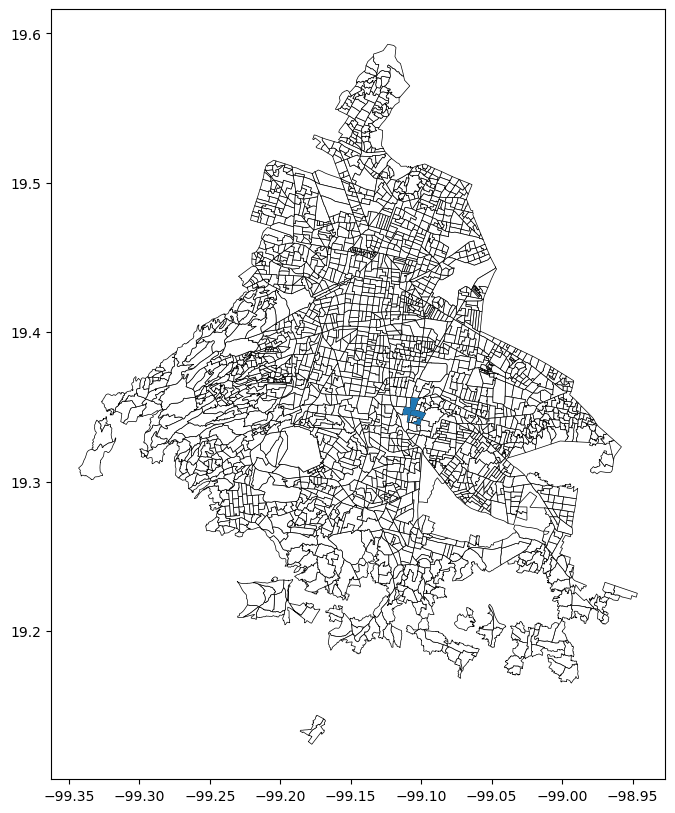

In [242]:
fig,ax=plt.subplots(figsize=(12,10))
alcshppob.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
#agpobtlafveci.plot(ax=ax,column='Qpob',legend=True,cmap='viridis')
#agpobtlafveci.plot(ax=ax,column='cluster',legend=True,cmap='viridis')
agpobtlafveci4.plot(ax=ax)

In [243]:
dftest9['pobreza'].value_counts()

pobreza
[ 0, 18]     2
(50, 70]     1
(18, 34]     1
(70, 100]    1
Name: count, dtype: int64

In [244]:
central_point = find_central_point_by_community(dftest9, dist_matrix_df)
print("Punto central:", central_point)



Índices con el valor máximo: ['0900700010483' '0900700010604' '0900700010727' '0900700012475'
 '0900700015003']
Punto central: geometry    POINT (-99.1347082883986 19.3745696178901)
pobreza                                       (18, 34]
CVE                                      0900700010483
IDS                                                 12
Name: 12, dtype: object


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Program

In [245]:
central_point

geometry    POINT (-99.1347082883986 19.3745696178901)
pobreza                                       (18, 34]
CVE                                      0900700010483
IDS                                                 12
Name: 12, dtype: object

In [246]:
central_point=[central_point[0],central_point[1]]
central_point

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\610654960.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  central_point=[central_point[0],central_point[1]]


[<POINT (-99.135 19.375)>, '(18, 34]']

In [247]:
root=dftest9[dftest9['geometry']==central_point[0]]
root

geometry   pobreza            CVE  IDS
12  POINT (-99.13471 19.37457)  (18, 34]  0900700010483   12

<Axes: >

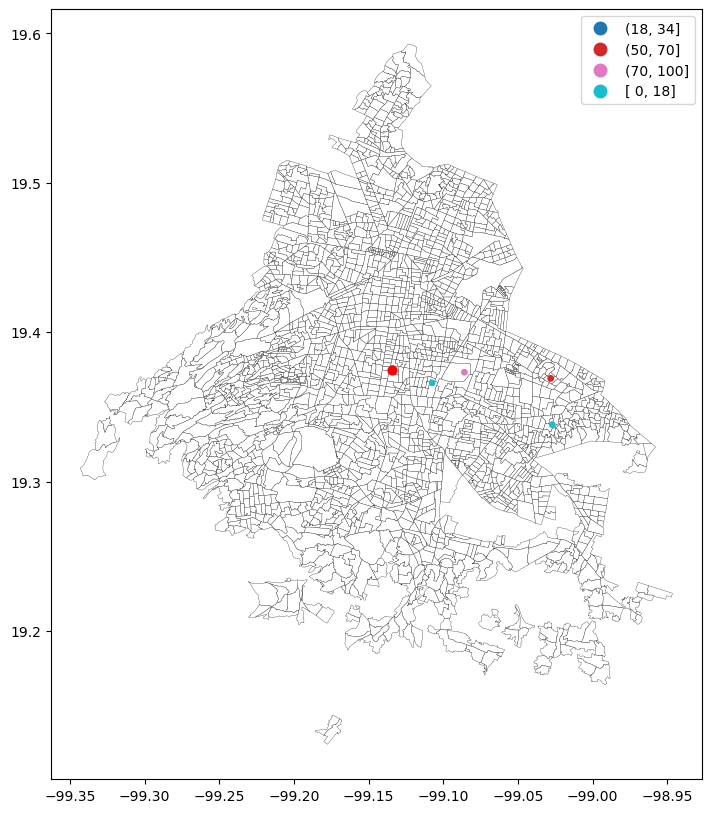

In [248]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest9.plot(ax=ax,column='pobreza',markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [249]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [250]:
grupo['pobreza']

12    (18, 34]
Name: pobreza, dtype: object

In [251]:
listapobreza

['(34, 50]']

In [252]:
dftest10=dftest9[dftest9['geometry'] != central_point[0]]
dftest10

geometry    pobreza            CVE  IDS
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19

In [253]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest10)):
    row2 = dftest10.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                      geometry   pobreza            CVE  IDS
12  POINT (-99.13471 19.37457)  (18, 34]  0900700010483   12


In [254]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [255]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

1

In [256]:
dftest11 = dftest10[~dftest10['IDS'].isin(listaids)]
dftest11['pobreza'].unique()

array(['(50, 70]', '[ 0, 18]', '(70, 100]'], dtype=object)

In [257]:
len(grupo)

1

<Axes: >

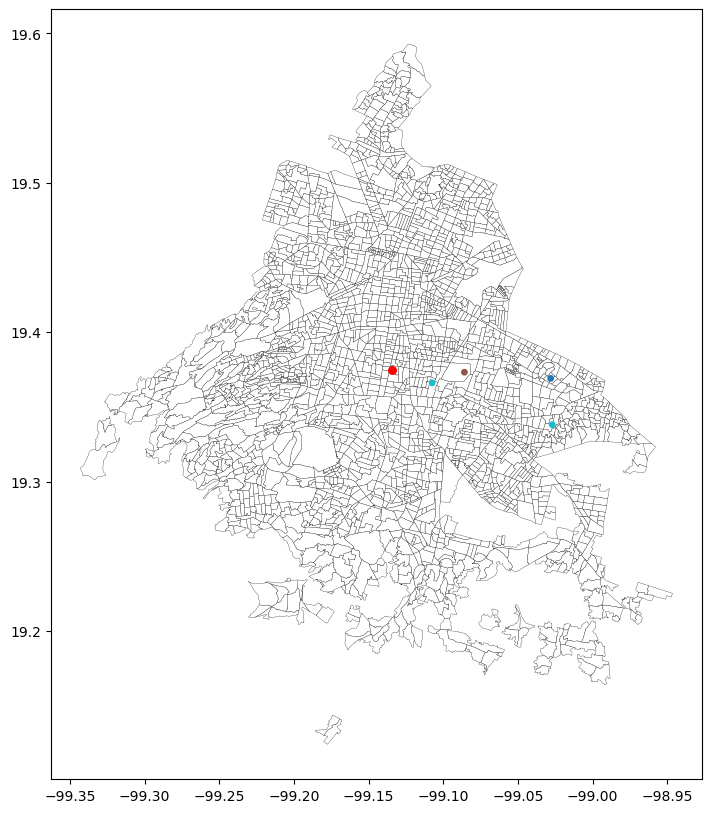

In [258]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest11.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [259]:
grupo['newgroup']=5

In [260]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo5= gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo5 = pd.concat([alcgrupo4, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo5=gpd.GeoDataFrame(alcgrupo4,geometry=alcgrupo4.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\3035769662.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [261]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo4)):
    row = alcgrupo4.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

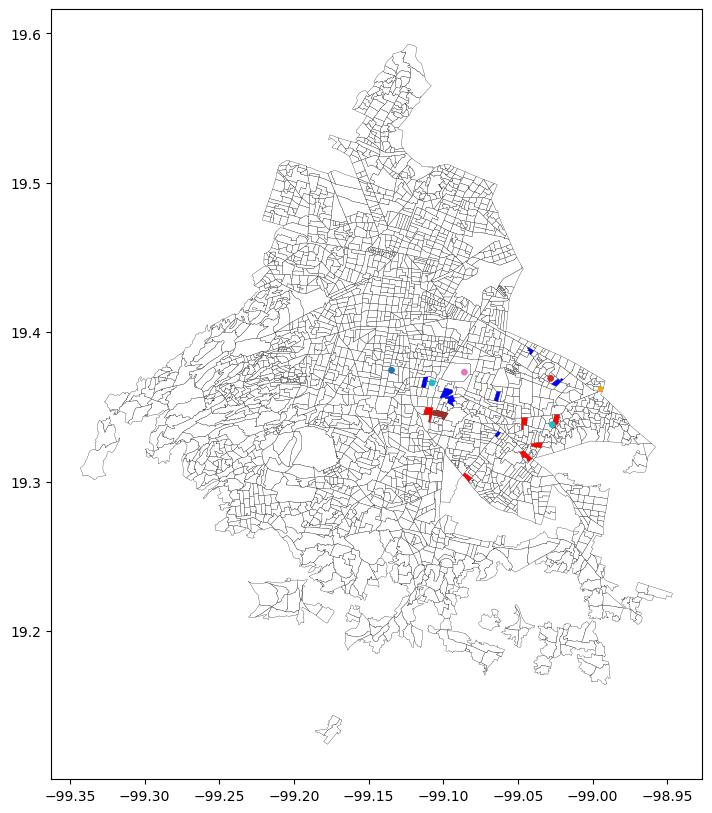

In [262]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo3.plot(ax=ax,color='orange')
alcgrupo4.plot(ax=ax,color='green')
alcgrupo5.plot(ax=ax,color='brown')
dftest9.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [263]:
grupo['pobreza'].unique()

array(['(18, 34]'], dtype=object)

In [264]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 5
    
    


alcshppob[alcshppob['grupo']==5]['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

In [265]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[5]

In [266]:

agpobtlafveci5 = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [267]:
agpobtlafveci5

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
906  0900700010483      09       007    0001       0483   
907  0900700010498      09       007    0001       0498   

                                              geometry Unnamed: 0  \
906  POLYGON ((-99.13057 19.37711, -99.13020 19.377...        744   
907  POLYGON ((-99.12991 19.37131, -99.12991 19.371...        745   

    Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
906                9     Ciudad de México       007  Iztapalapa   
907                9     Ciudad de México       007  Iztapalapa   

    Rango de pobreza (%) Rango de pobreza extrema (%) CVE_AGEB_y  \
906             (18, 34]                     [ 0, 20]       0483   
907             (18, 34]                     [ 0, 20]       0498   

    Clave localidad grupo  
906               1     5  
907               1     5

In [268]:
agpobtlafveci5=gpd.GeoDataFrame(agpobtlafveci5,geometry=agpobtlafveci5.geometry)

In [269]:
agpobtlafveci5['Rango de pobreza (%)'].unique()

array(['(18, 34]'], dtype=object)

<Axes: >

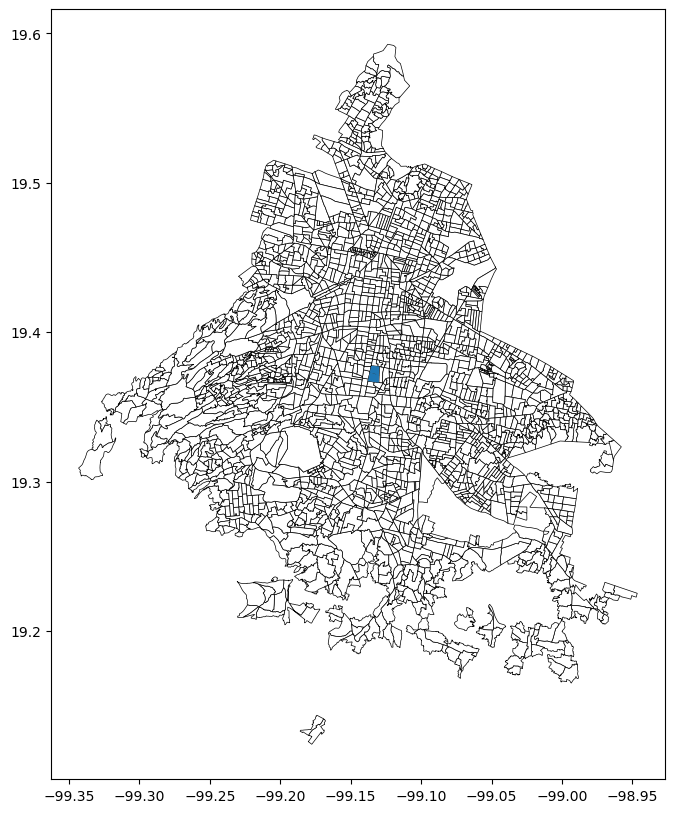

In [270]:
fig,ax=plt.subplots(figsize=(12,10))
alcshppob.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
#agpobtlafveci.plot(ax=ax,column='Qpob',legend=True,cmap='viridis')
#agpobtlafveci.plot(ax=ax,column='cluster',legend=True,cmap='viridis')
agpobtlafveci5.plot(ax=ax)

In [271]:
dftest11['pobreza'].value_counts()

pobreza
[ 0, 18]     2
(50, 70]     1
(70, 100]    1
Name: count, dtype: int64

In [272]:
central_point = find_central_point_by_community(dftest11, dist_matrix_df)
print("Punto central:", central_point)



Índices con el valor máximo: ['0900700010604' '0900700010727' '0900700012475' '0900700015003']
Punto central: geometry    POINT (-99.1075050885205 19.3660703371296)
pobreza                                       [ 0, 18]
CVE                                      0900700010727
IDS                                                  9
Name: 9, dtype: object


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Program

In [273]:
central_point=[central_point[0],central_point[1]]
central_point

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\610654960.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  central_point=[central_point[0],central_point[1]]


[<POINT (-99.108 19.366)>, '[ 0, 18]']

In [274]:
root=dftest11[dftest11['geometry']==central_point[0]]
root

geometry   pobreza            CVE  IDS
9  POINT (-99.10751 19.36607)  [ 0, 18]  0900700010727    9

<Axes: >

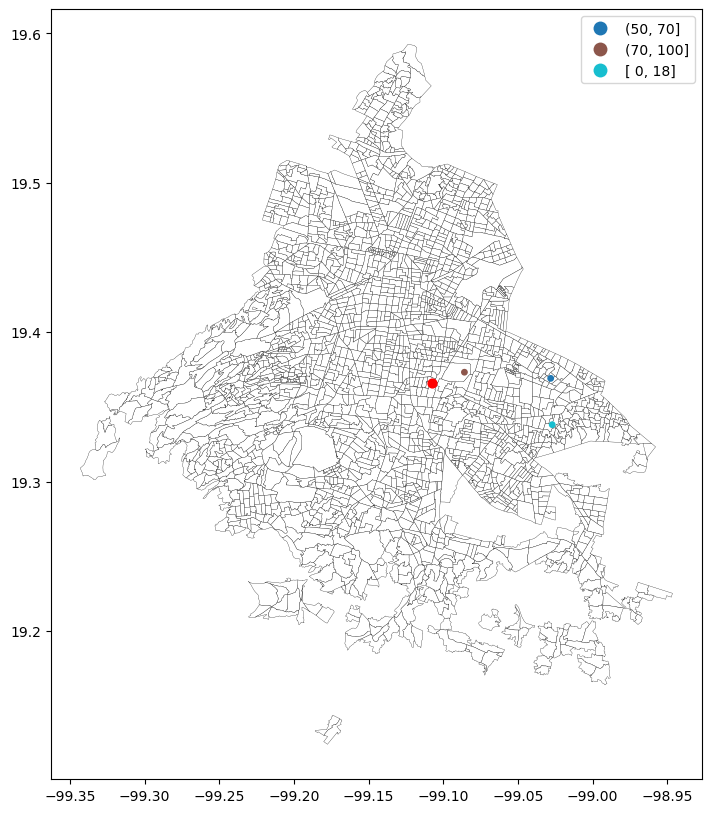

In [275]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
dftest11.plot(ax=ax,column='pobreza',markersize=15,legend=True,categorical=True)
root.plot(ax=ax,markersize=40,color='red')


In [276]:
grupo=gpd.GeoDataFrame(root,geometry=root.geometry)
grupo.columns

Index(['geometry', 'pobreza', 'CVE', 'IDS'], dtype='object')

In [277]:
grupo['pobreza']

9    [ 0, 18]
Name: pobreza, dtype: object

In [278]:
listapobreza

['(34, 50]']

In [279]:
dftest12=dftest11[dftest11['geometry'] != central_point[1]]
dftest12

geometry    pobreza            CVE  IDS
4   POINT (-99.02814 19.36908)   (50, 70]  0900700010604    4
9   POINT (-99.10751 19.36607)   [ 0, 18]  0900700010727    9
18  POINT (-99.02713 19.33807)   [ 0, 18]  0900700015003   18
19  POINT (-99.08589 19.37319)  (70, 100]  0900700012475   19

In [280]:
import pandas as pd

# Supongamos que tienes los DataFrames dftest2 y grupo, y la matriz de distancias dist_matrix_df ya definidos
# También asumiendo que lim_inf_pob, lim_sup_pob, y mean_distance ya están definidos


# Itera sobre las filas de dftest2
for i in range(len(dftest12)):
    row2 = dftest12.iloc[i]
    ind2 = row2['IDS']
    #pob2 = row2['poblacion']
    rangpob2 = row2['pobreza']
    
    for j in range(len(grupo)):
        row1 = grupo.iloc[j]
        ind1 = row1['IDS']
        #pob1 = row1['poblacion']
        rangpob = row1['pobreza']
        
        distance_value = dist_matrix_df.loc[ind1, ind2]
        if (distance_value <= mean_distance) and (rangpob == rangpob2):
            
            grupo = pd.concat([grupo, pd.DataFrame([row2])], ignore_index=True)
            break  # Salir del bucle interno después de agregar la fila

print(grupo)



                     geometry   pobreza            CVE  IDS
0  POINT (-99.10751 19.36607)  [ 0, 18]  0900700010727    9
1  POINT (-99.10751 19.36607)  [ 0, 18]  0900700010727    9


In [281]:
grupo['pobreza'].unique()

array(['[ 0, 18]'], dtype=object)

In [282]:
listaids=grupo['IDS'].values.tolist()
len(grupo)

2

In [283]:
dftest13 = dftest12[~dftest12['IDS'].isin(listaids)]
dftest13['pobreza'].unique()

array(['(50, 70]', '[ 0, 18]', '(70, 100]'], dtype=object)

In [284]:
len(grupo)

2

<Axes: >

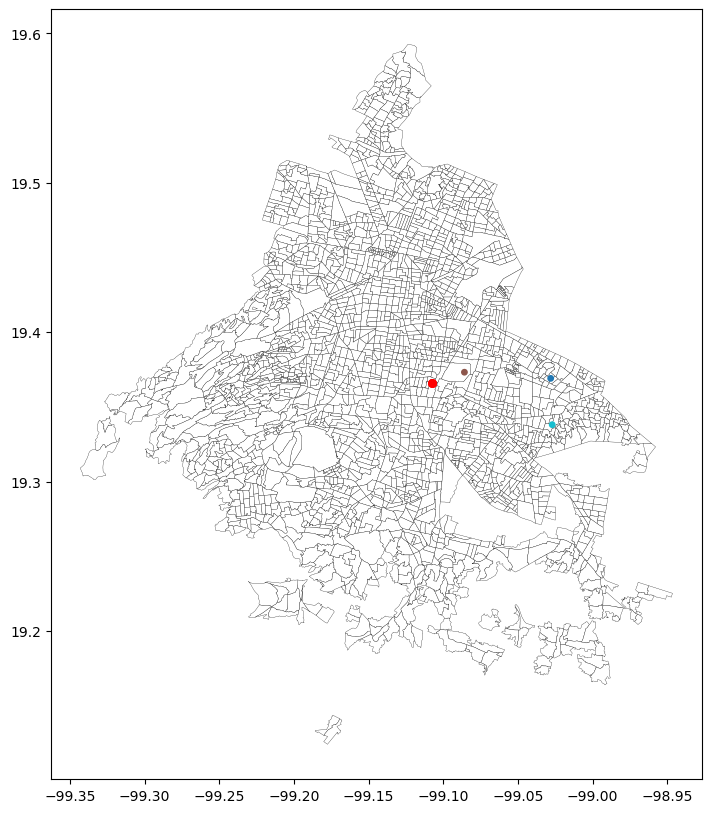

In [285]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
grupo.plot(ax=ax,markersize=30,color='red')

dftest13.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [286]:
grupo['newgroup']=6

In [287]:
# Crear un DataFrame vacío para almacenar los resultados
alcgrupo6= gpd.GeoDataFrame()

# Lista de IDs de ageb y valores de cluster de grupo
agsgru = grupo.CVE.values.tolist()
lista_cluster = grupo.newgroup.values.tolist()

# Asignar el valor del cluster a alcshp
filas_a_agregar = []
for i in range(len(alcal)):
    row2 = alcal.iloc[i]
    if row2.CVEGEO in agsgru:
        # Obtener el valor del cluster correspondiente a la ageb de alcshp
        cluster_value = lista_cluster[agsgru.index(row2.CVEGEO)]
        # Asignar el valor del cluster a la columna 'cluster' en alcshp
        row2['cluster'] = cluster_value
        # Agregar la fila a la lista de filas a agregar
        filas_a_agregar.append(row2)

# Concatenar las filas a agregar al DataFrame alcgrupo1
alcgrupo6 = pd.concat([alcgrupo4, pd.DataFrame(filas_a_agregar)], ignore_index=True)

# Mostrar el resultado
alcgrupo6=gpd.GeoDataFrame(alcgrupo4,geometry=alcgrupo4.geometry)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\3896824988.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row2['cluster'] = cluster_value


In [288]:
# Crear una columna 'cluster' en alcshp
alcal['cluster'] = ''

# Iterar sobre cada fila de alcgrupo1
for i in range(len(alcgrupo4)):
    row = alcgrupo4.iloc[i]
    ageb = row['CVEGEO']
    cluster_value = row['cluster']
    
    # Buscar la fila correspondiente en alcshp y asignar el valor del cluster
    alcal.loc[alcal['CVEGEO'] == ageb, 'cluster'] = cluster_value


<Axes: >

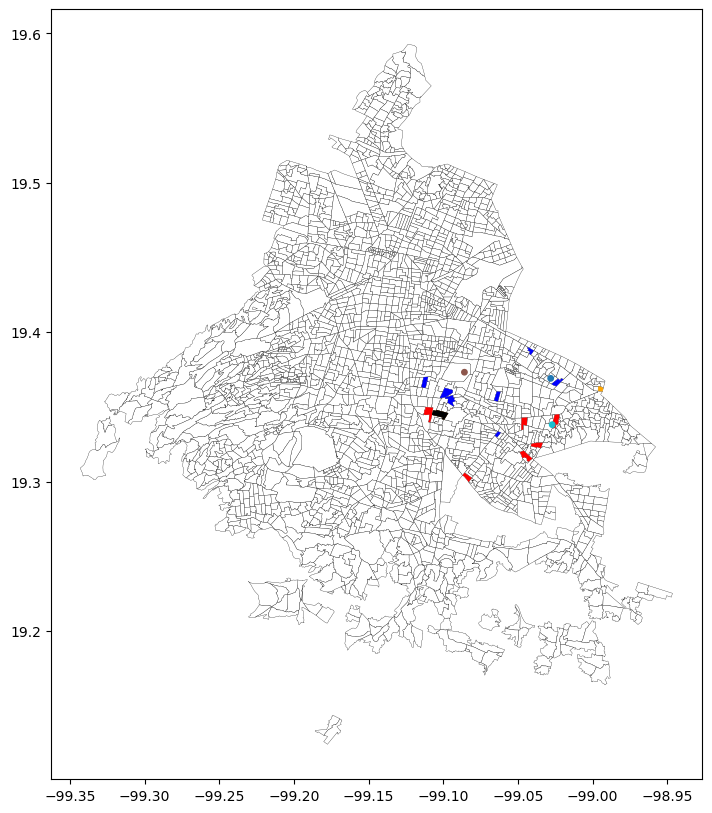

In [289]:
fig,ax=plt.subplots(figsize=(12,10))
alcal.plot(ax=ax,color='white',edgecolor='black',linewidth=0.2)
alcgrupo2.plot(ax=ax,color='blue')
alcgrupo1.plot(ax=ax,color='red')
alcgrupo3.plot(ax=ax,color='orange')
alcgrupo4.plot(ax=ax,color='green')
alcgrupo5.plot(ax=ax,color='brown')
alcgrupo6.plot(ax=ax,color='black')
dftest13.plot(ax=ax,column='pobreza',markersize=15,categorical=True)

In [290]:
grupo['pobreza'].unique()

array(['[ 0, 18]'], dtype=object)

In [291]:
listag=grupo['CVE'].values.tolist()

alcshppob['grupo']=''

for ageb in listag:
    # Asignar el valor 1 en 'grupo' para las filas que tienen 'CVE_AGEB_x' igual a ageb y 'alcaldia_hechos' igual a alcaldia
    alcshppob.loc[(alcshppob['CVEGEO'] == ageb), 'grupo'] = 6
    
    


alcshppob[alcshppob['grupo']==6]['Rango de pobreza (%)'].unique()

array(['[ 0, 18]'], dtype=object)

In [292]:
gruposcat=alcshppob.grupo.unique()
gruposcat = [x for x in gruposcat if isinstance(x, (int, float))]
gruposcat

[6]

In [293]:

agpobtlafveci6 = obtener_poligonos_vecinos_extendidos(alcshppob, w_queen, gruposcat)

C:\Users\Luis Vilches\AppData\Local\Temp\ipykernel_1828\828583937.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fags = pd.concat([fags, dif])


In [294]:
agpobtlafveci6

CVEGEO CVE_ENT CVE_MUN_x CVE_LOC CVE_AGEB_x  \
883   0900700010727      09       007    0001       0727   
1121  0900700015446      09       007    0001       5446   
948   0900700010958      09       007    0001       0958   
860   0900700011180      09       007    0001       1180   
861   0900700011195      09       007    0001       1195   

                                               geometry Unnamed: 0  \
883   POLYGON ((-99.10576 19.36717, -99.10514 19.366...        764   
1121  POLYGON ((-99.10514 19.36874, -99.10576 19.367...       1114   
948   POLYGON ((-99.11525 19.35694, -99.11477 19.358...        784   
860   POLYGON ((-99.11525 19.35694, -99.11469 19.356...        801   
861   POLYGON ((-99.10715 19.35622, -99.10715 19.356...        802   

     Clave de entidad Entidad \nfederativa CVE_MUN_y   Municipio  \
883                 9     Ciudad de México       007  Iztapalapa   
1121                9     Ciudad de México       007  Iztapalapa   
948                 9     Ciudad de México       007  Iztapalapa   
860                 9     Ciudad de México       007  Iztapalapa   
861                 9     Ciudad de México       007  Iztapalapa   

     Rango de pobreza (%) Rango de pobreza extrema (%) CVE_AGEB_y  \
883              [ 0, 18]                     [ 0, 20]       0727   
1121             [ 0, 18]                     [ 0, 20]       5446   
948              [ 0, 18]                     [ 0, 20]       0958   
860              [ 0, 18]                     [ 0, 20]       1180   
861              [ 0, 18]                     [ 0, 20]       1195   

     Clave localidad grupo  
883                1     6  
1121               1     6  
948                1     6  
860                1     6  
861                1     6

In [295]:
agpobtlafveci6=gpd.GeoDataFrame(agpobtlafveci6,geometry=agpobtlafveci6.geometry)

In [296]:
agpobtlafveci6['Rango de pobreza (%)'].unique()

array(['[ 0, 18]'], dtype=object)

In [297]:
agpob=pd.concat([agpobtlafveci,agpobtlafveci2,agpobtlafveci3,agpobtlafveci4,
                agpobtlafveci5,agpobtlafveci6])

In [304]:
original=pd.concat([alcgrupo1,alcgrupo2,alcgrupo3,alcgrupo4,alcgrupo5,alcgrupo6])

In [354]:
alcgrupo6

CVEGEO   POBREZA POBREZAEX   ID  \
0  0900700011388  (34, 50]  [ 0, 20]  818   

                                            geometry  cluster  
0  POLYGON ((-99.10246 19.34732, -99.10225 19.347...        4

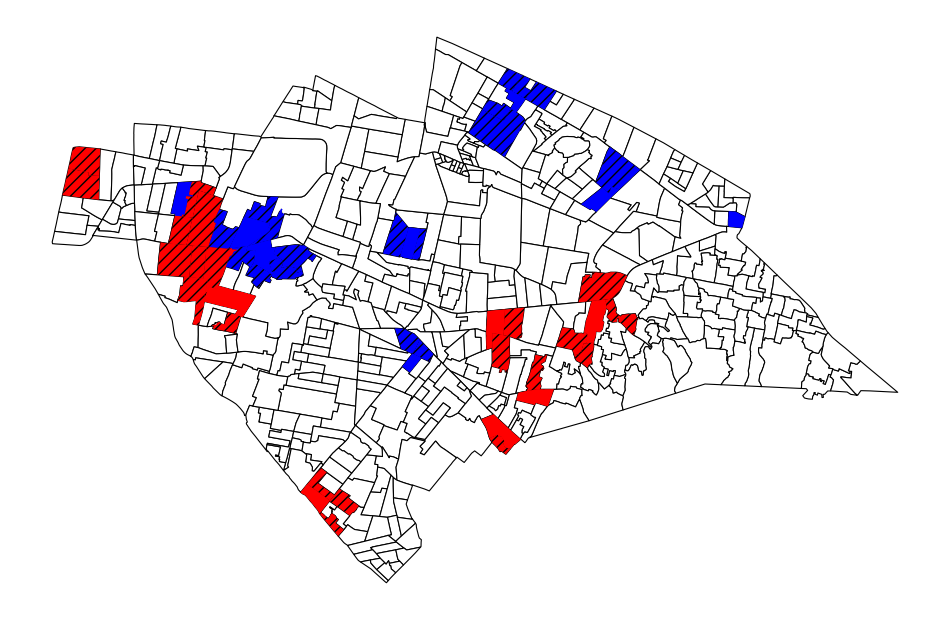

In [356]:
fig,ax=plt.subplots(figsize=(12,10))
alcalizt.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)
agpobtlafveci.plot(ax=ax,color='red',hatch='///')
alcgrupo1.plot(ax=ax,color='red')

agpobtlafveci2.plot(ax=ax,color='blue',hatch='///')
alcgrupo2.plot(ax=ax,color='blue')

agpobtlafveci3.plot(ax=ax,color='blue',hatch='///')
alcgrupo3.plot(ax=ax,color='blue')

agpobtlafveci4.plot(ax=ax,color='red',hatch='///')
alcgrupo4.plot(ax=ax,color='red')

agpobtlafveci5.plot(ax=ax,color='red',hatch='///')
alcgrupo5.plot(ax=ax,color='red')

agpobtlafveci6.plot(ax=ax,color='red',hatch='///')
alcgrupo6.plot(ax=ax,color='red')
ax.set_xticks([])  # Quita los ticks del eje X
ax.set_yticks([])  # Quita los ticks del eje Y
ax.set_frame_on(False)  # Elimina el marco alrededor del gráfico

plt.savefig("mapa_por_cluster1_7.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [756]:
dftest13

geometry   pobreza            CVE  IDS
55  POINT (-99.05046 19.31869)  (50, 70]  0900700012051   55
72  POINT (-99.18814 19.25995)  (34, 50]  0901200011744   72